# Gain scheduling and Auto tuning
In this notebook the topic of gain scheduling is studied.
## Preparation
Study the relevant chapters in
- "Predictive and Adaptive Control" R. Johansson 
- Chapter 9 "Adaptive Control" K.J. Åström
- [Slides from control system synthesis](http://www.control.lth.se/media/Education/DoctorateProgram/2016/Control%20System%20Synthesis/gainscheduling.pdf)

## The processes
The processes studied in this session are third order systems with two poles in $s=-0.5$ and one pole in -2.
$$P(s) = \dfrac{1}{(2s+1)^2(0.5s+1)}$$
with or without input nonlinearity.

## Installation
- First of all, you need Julia installed, see https://julialang.org/downloads/
- You also need [IJulia](https://github.com/JuliaLang/IJulia.jl#installation), which in turn requires Jupyter.
- Once Julia is up and running, the following julia code only has to be run once, it installs the relevant packages.

In [1]:
Pkg.add("NLOpt")

The code below must be run once every time the kernel is restarted

In [125]:
using ControlSystems, OrdinaryDiffEq, Plots, Interact
gr(show=false, size=(800,400)) # Set defaults for plotting

Plots.GRBackend()

We now proceed to define the process model and some parameters for our simulation

In [126]:
P              = tf(1,[2.,1])^2*tf(1,[0.5,1])  # Process model
h              = 0.1             # Sample time (only used for plots)
Ps             = ss(P)           # State-space representation of process model
reference(x,t) = 1.;             # Reference generator (step function)

Next we define a simulation object and simulate the system with a P-controller.
- Change the value of the gain $K$ using the slider and try to get a feeling for how the system behaves.

In [127]:
s      = Simulator(Ps)
x0     = [0.,0,0] # Initial state
Tf     = 20              # Length of experiments (seconds)
t      = 0:h:Tf          # Time vector
tspan  = (0.0,Tf)

(0.0, 20)

Interact.Options{:SelectionSlider,Any}(311: "input-85" = 9.795918367346939 Any , "K", 9.795918367346939, "9.795918367346939", 25, Interact.OptionDict(DataStructures.OrderedDict{Any,Any}("0.0"=>0.0,"0.40816326530612246"=>0.408163,"0.8163265306122449"=>0.816327,"1.2244897959183674"=>1.22449,"1.6326530612244898"=>1.63265,"2.0408163265306123"=>2.04082,"2.4489795918367347"=>2.44898,"2.857142857142857"=>2.85714,"3.2653061224489797"=>3.26531,"3.673469387755102"=>3.67347…), Dict{Any,Any}(Pair{Any,Any}(9.38776, "9.387755102040817"),Pair{Any,Any}(8.57143, "8.571428571428571"),Pair{Any,Any}(1.22449, "1.2244897959183674"),Pair{Any,Any}(1.63265, "1.6326530612244898"),Pair{Any,Any}(6.93878, "6.938775510204081"),Pair{Any,Any}(12.6531, "12.653061224489797"),Pair{Any,Any}(19.5918, "19.591836734693878"),Pair{Any,Any}(18.3673, "18.367346938775512"),Pair{Any,Any}(20.0, "20.0"),Pair{Any,Any}(3.67347, "3.673469387755102")…)), Any[], Any[], true, "horizontal")

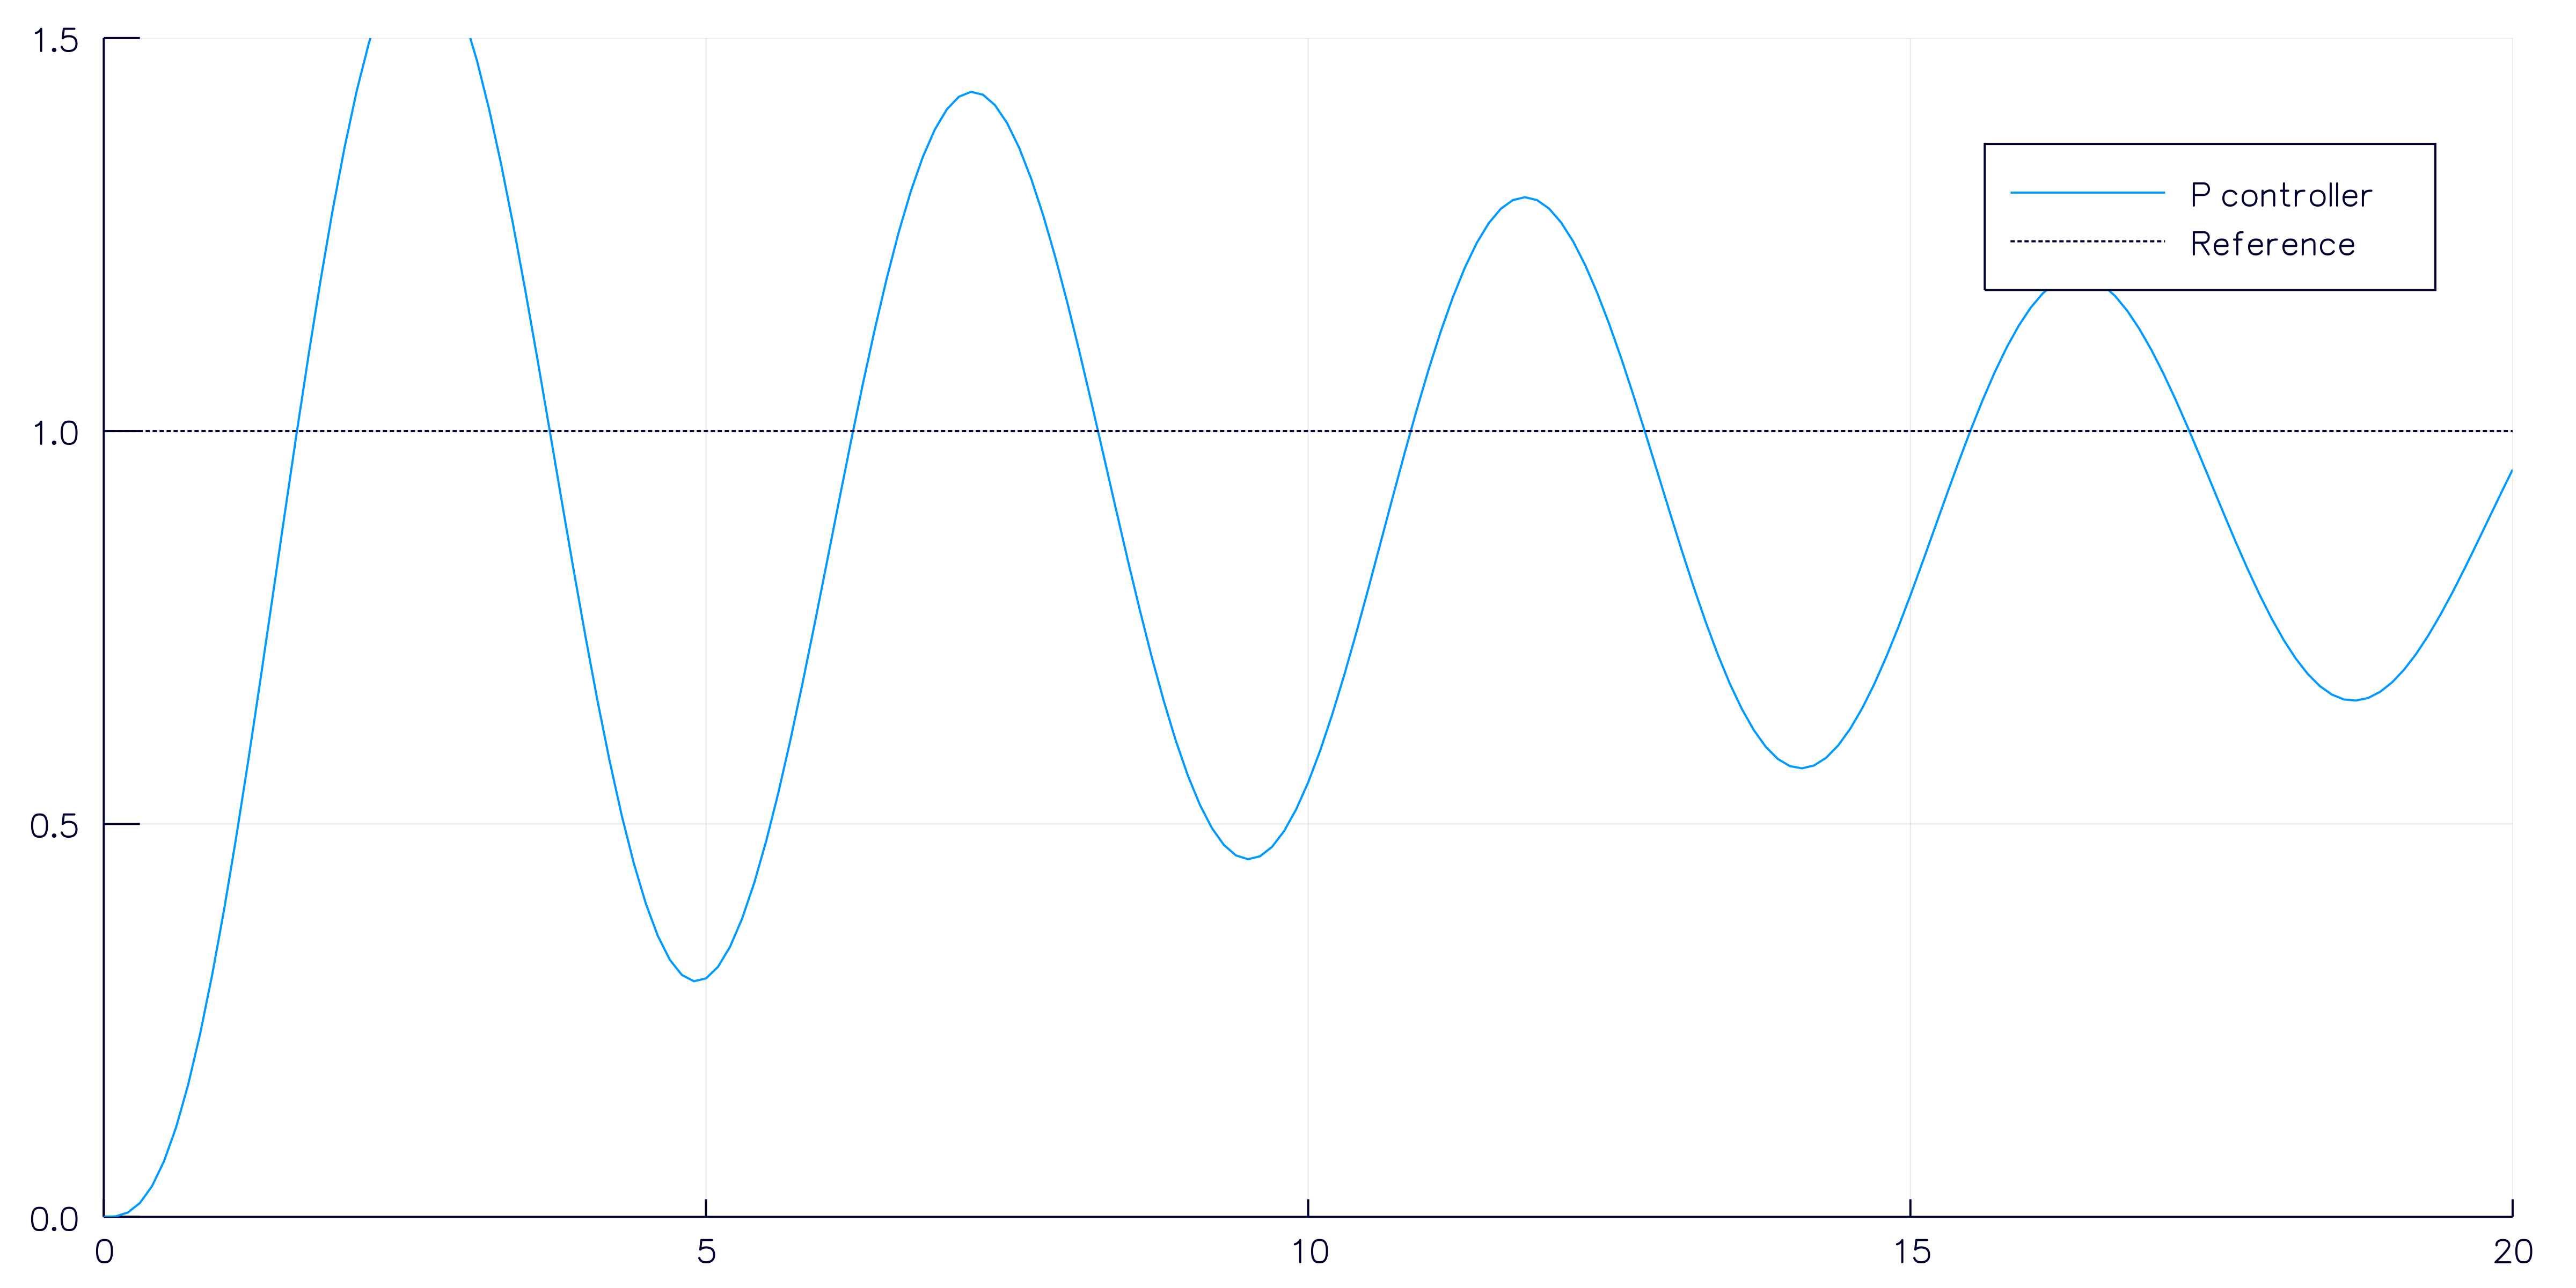

In [129]:
@manipulate for K = linspace(0,20,50)
    global os, sol1
    controller(e) = K*e
    os     = OutputFeedbackSimulator(Ps,reference,controller)
    sol1   = solve(os, x0, tspan, Tsit5()) # Simulate the system
    plot(t, os.y(sol1, t)[:], lab="P controller")
    plot!([tspan...], [1,1], lab="Reference", l=:dash, c=:black, ylims=(0,1.5))
end

- As you may notice, the stationary error never vanishes. How can one obtain zero stationary error for a fixed reference value while keeping a P controller?
- Modify the function `controller` to get a smaller stationary error.

Let's step up the game and control the system with a PID controller. Use [Ziegler–Nichols frequency method](https://en.wikipedia.org/wiki/Ziegler%E2%80%93Nichols_method) to tune a PID controller for the system. 
You can use the code above to find the critical gain. You can compare the result with a numerical root finding algorithm applied to the process model, see below
- Compare the results with manual tuning.

In [5]:
using Roots
fzero(K->maximum(real.(pole(feedback(P,tf(K))))), 1, 20)

12.499999999999998

Below we show the root locus of the system, what does the plot tell you?

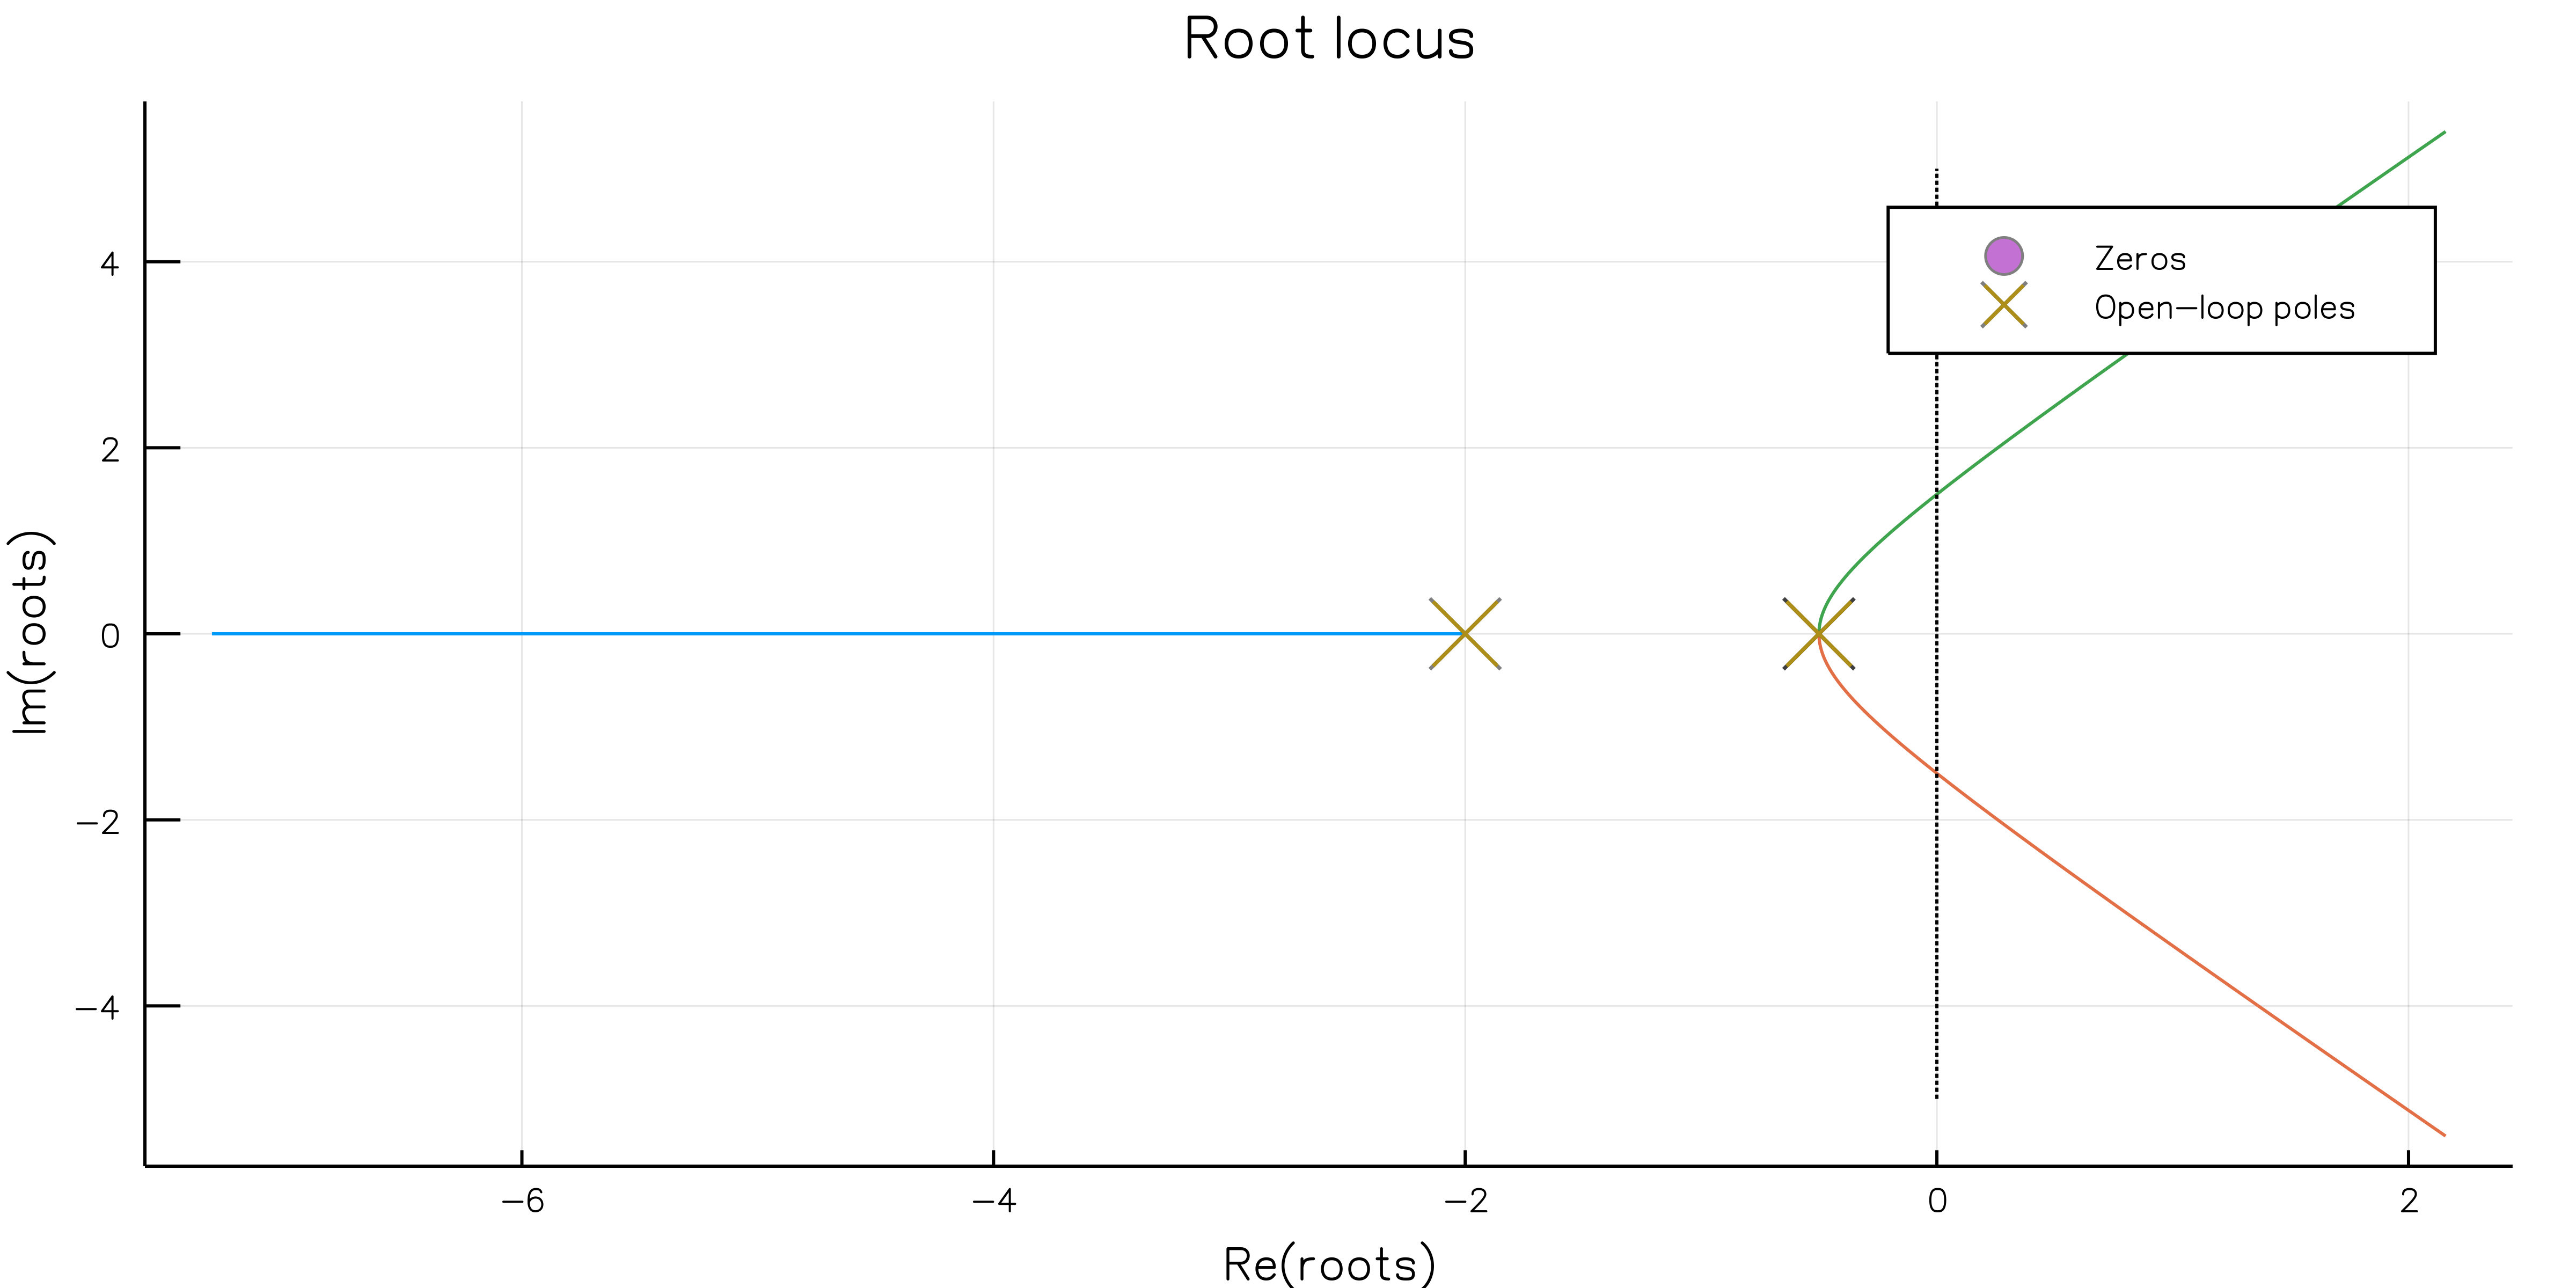

In [6]:
rlocusplot(P); plot!([0,0],[-5,5],l=(:dash,:black),lab="")

Interact.Options{:SelectionSlider,Any}(5: "input-2" = 4.8979591836734695 Any , "kp", 4.8979591836734695, "4.8979591836734695", 25, Interact.OptionDict(DataStructures.OrderedDict{Any,Any}("0.0"=>0.0,"0.20408163265306123"=>0.204082,"0.40816326530612246"=>0.408163,"0.6122448979591837"=>0.612245,"0.8163265306122449"=>0.816327,"1.0204081632653061"=>1.02041,"1.2244897959183674"=>1.22449,"1.4285714285714286"=>1.42857,"1.6326530612244898"=>1.63265,"1.836734693877551"=>1.83673…), Dict{Any,Any}(Pair{Any,Any}(8.77551, "8.775510204081632"),Pair{Any,Any}(7.55102, "7.551020408163265"),Pair{Any,Any}(8.36735, "8.36734693877551"),Pair{Any,Any}(9.38776, "9.387755102040817"),Pair{Any,Any}(8.57143, "8.571428571428571"),Pair{Any,Any}(1.22449, "1.2244897959183674"),Pair{Any,Any}(1.63265, "1.6326530612244898"),Pair{Any,Any}(6.93878, "6.938775510204081"),Pair{Any,Any}(6.32653, "6.326530612244898"),Pair{Any,Any}(3.67347, "3.673469387755102")…)), Any[], Any[], true, "horizontal")

Interact.Options{:SelectionSlider,Any}(7: "input-3" = 2.4489795918367347 Any , "ki", 2.4489795918367347, "2.4489795918367347", 25, Interact.OptionDict(DataStructures.OrderedDict{Any,Any}("0.0"=>0.0,"0.10204081632653061"=>0.102041,"0.20408163265306123"=>0.204082,"0.30612244897959184"=>0.306122,"0.40816326530612246"=>0.408163,"0.5102040816326531"=>0.510204,"0.6122448979591837"=>0.612245,"0.7142857142857143"=>0.714286,"0.8163265306122449"=>0.816327,"0.9183673469387755"=>0.918367…), Dict{Any,Any}(Pair{Any,Any}(1.22449, "1.2244897959183674"),Pair{Any,Any}(1.63265, "1.6326530612244898"),Pair{Any,Any}(4.79592, "4.795918367346939"),Pair{Any,Any}(2.14286, "2.142857142857143"),Pair{Any,Any}(3.77551, "3.7755102040816326"),Pair{Any,Any}(3.67347, "3.673469387755102"),Pair{Any,Any}(2.04082, "2.0408163265306123"),Pair{Any,Any}(0.612245, "0.6122448979591837"),Pair{Any,Any}(3.87755, "3.877551020408163"),Pair{Any,Any}(1.12245, "1.1224489795918366")…)), Any[], Any[], true, "horizontal")

Interact.Options{:SelectionSlider,Any}(9: "input-4" = 9.795918367346939 Any , "kd", 9.795918367346939, "9.795918367346939", 25, Interact.OptionDict(DataStructures.OrderedDict{Any,Any}("0.0"=>0.0,"0.40816326530612246"=>0.408163,"0.8163265306122449"=>0.816327,"1.2244897959183674"=>1.22449,"1.6326530612244898"=>1.63265,"2.0408163265306123"=>2.04082,"2.4489795918367347"=>2.44898,"2.857142857142857"=>2.85714,"3.2653061224489797"=>3.26531,"3.673469387755102"=>3.67347…), Dict{Any,Any}(Pair{Any,Any}(9.38776, "9.387755102040817"),Pair{Any,Any}(8.57143, "8.571428571428571"),Pair{Any,Any}(1.22449, "1.2244897959183674"),Pair{Any,Any}(1.63265, "1.6326530612244898"),Pair{Any,Any}(6.93878, "6.938775510204081"),Pair{Any,Any}(12.6531, "12.653061224489797"),Pair{Any,Any}(19.5918, "19.591836734693878"),Pair{Any,Any}(18.3673, "18.367346938775512"),Pair{Any,Any}(20.0, "20.0"),Pair{Any,Any}(3.67347, "3.673469387755102")…)), Any[], Any[], true, "horizontal")

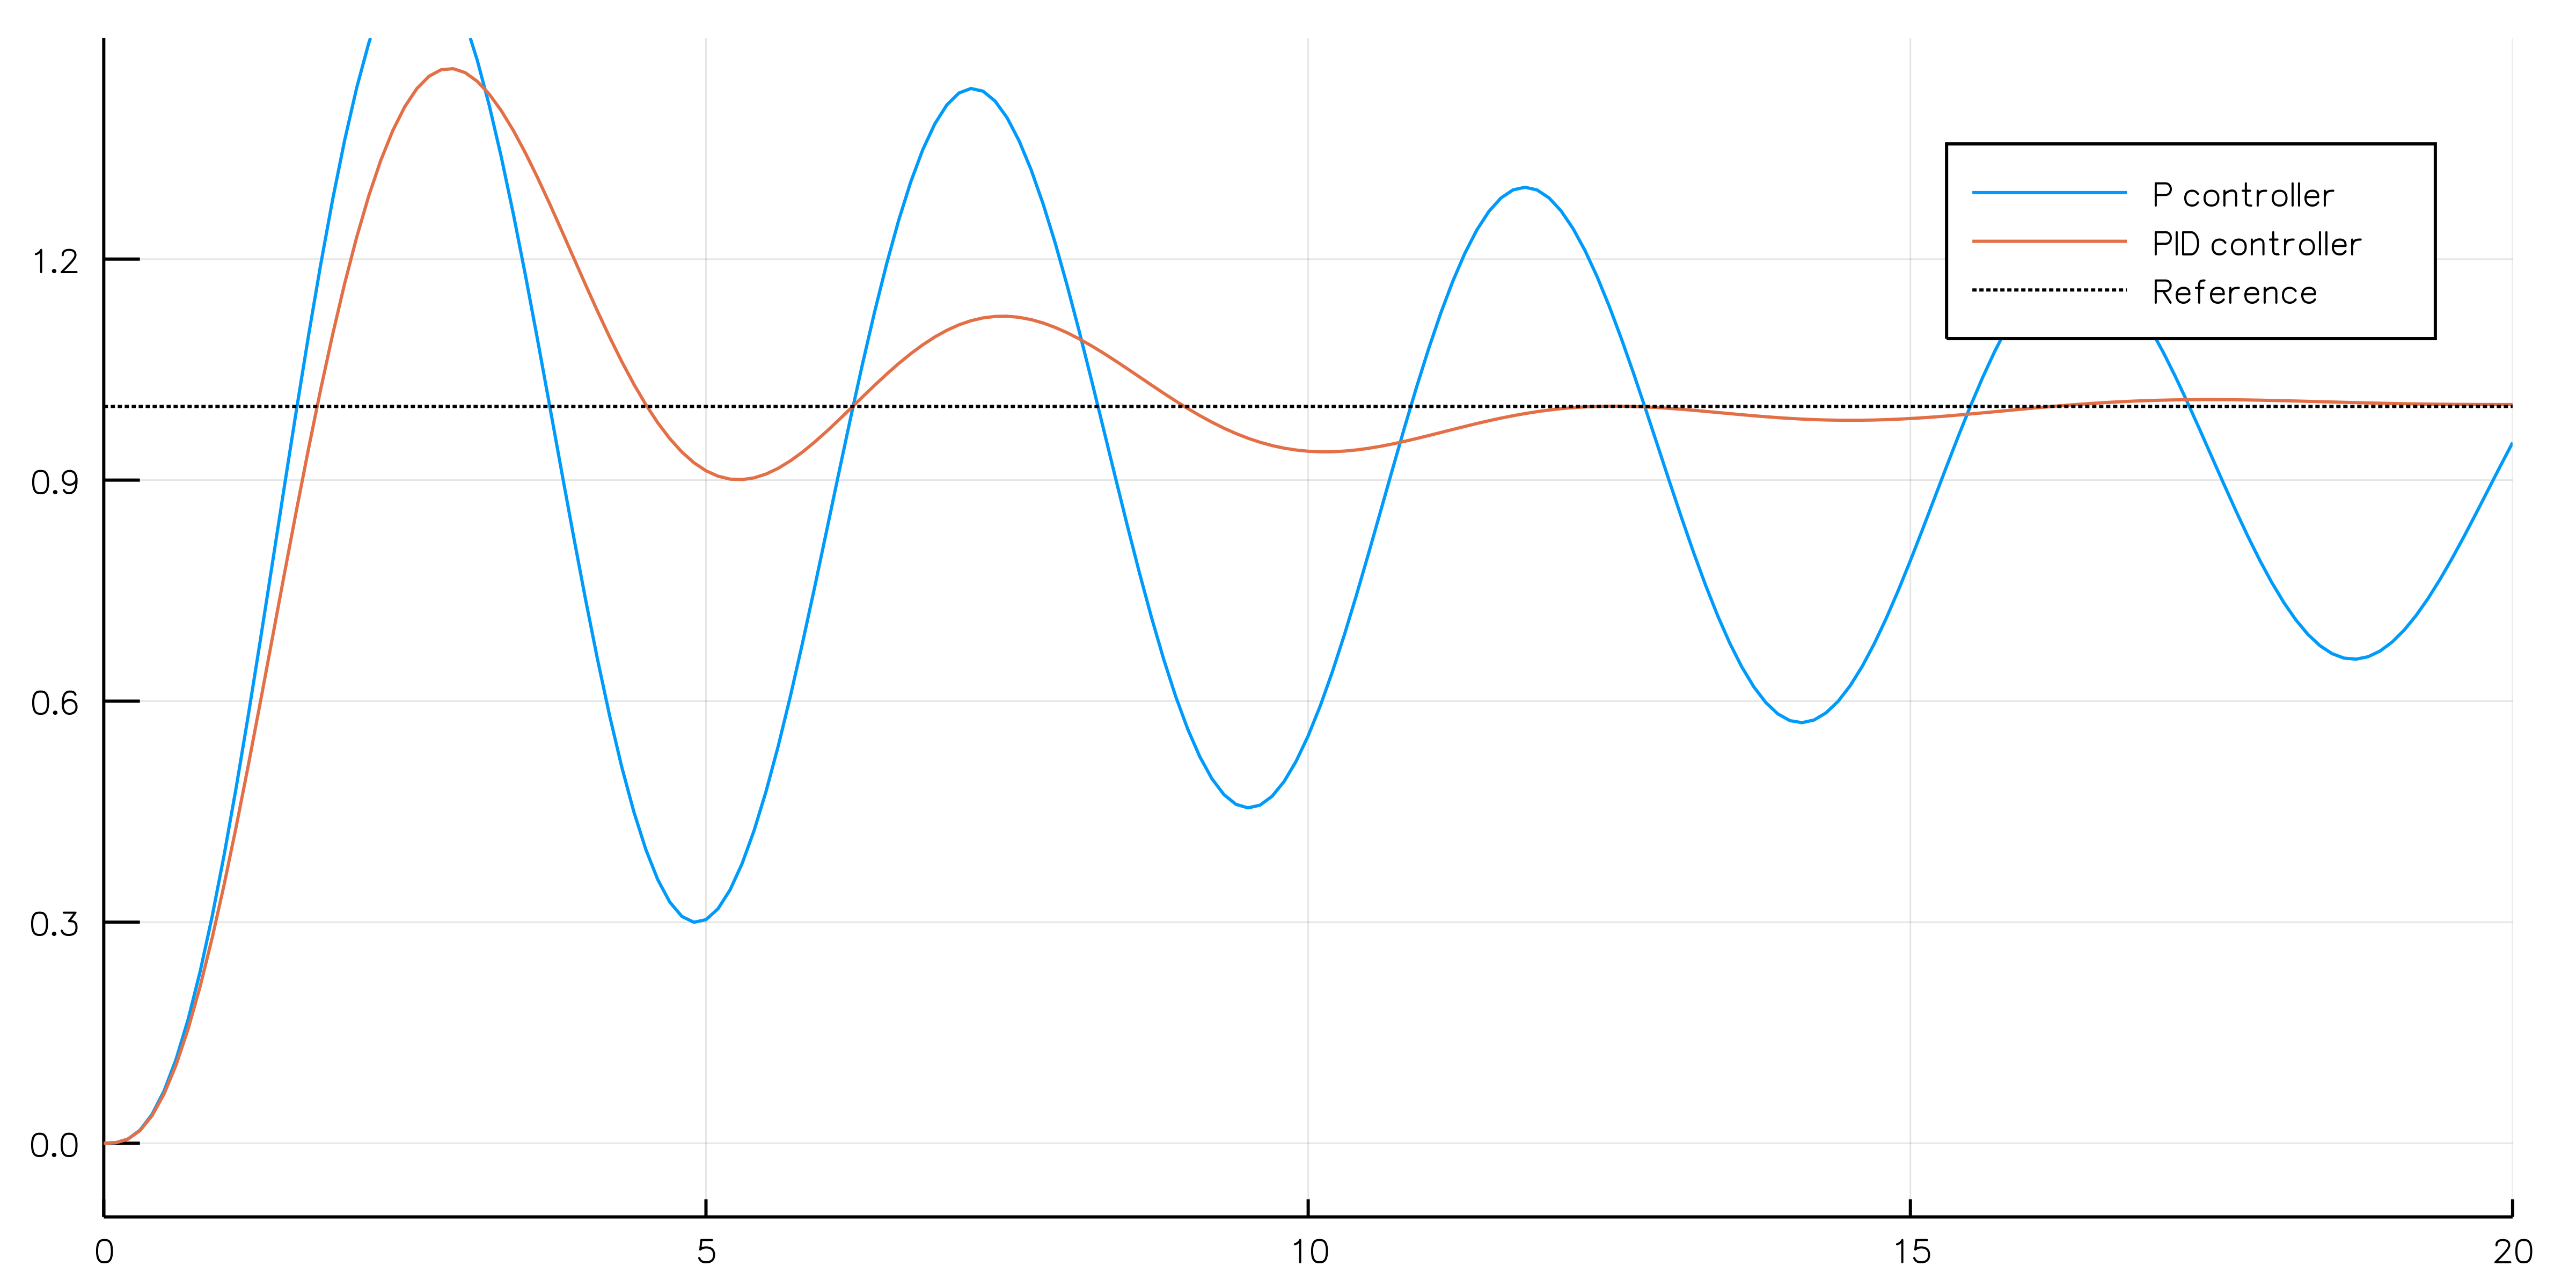

In [7]:
conditions  = [(x,y,r) -> true]
Tf          = 20              # Length of experiments (seconds)
t           = 0:h:Tf          # Time vector
tspan       = (0.0,Tf)
x0          = [0.,0,0]

@manipulate for kp = linspace(0,10,50),ki = linspace(0,5,50),kd = linspace(0,20,50)
    controllers = [pid(kp=kp, ki=ki, kd=kd)]
    global gs, sol1, sol2
    gs    = GainSchedulingSimulator(Ps, reference, controllers, conditions)
    sol2  = solve(gs, x0, tspan, Tsit5())
    plot(t, os.y(sol1, t)[:], lab="P controller")
    plot!(t, gs.y(sol2, t)[:], lab="PID controller")
    plot!([tspan...], [1,1], lab="Reference", l=(:dash, :black), ylims=(-0.1,1.5))
end

## Auto tuning
Even with interactive tools, tuning a PID controller by hand can be difficult. A basic control course teaches us how to design a PID controller based on, e.g., pole placement. Here, we will formulate an optimization problem where we optimize a cost function $J(k_p,k_i,k_d)$ based on the step response of the closed-loop system
$$J(k_p,k_i,k_d) \quad=\quad \dfrac{1}{T_f}\int_0^{T_f} |r(t)-y(t)| dt \quad=\quad \dfrac{1}{T_f}\int_0^{T_f} |e(t)|dt$$

 27.178509 seconds (27.52 M allocations: 1.334 GiB, 1.89% gc time)


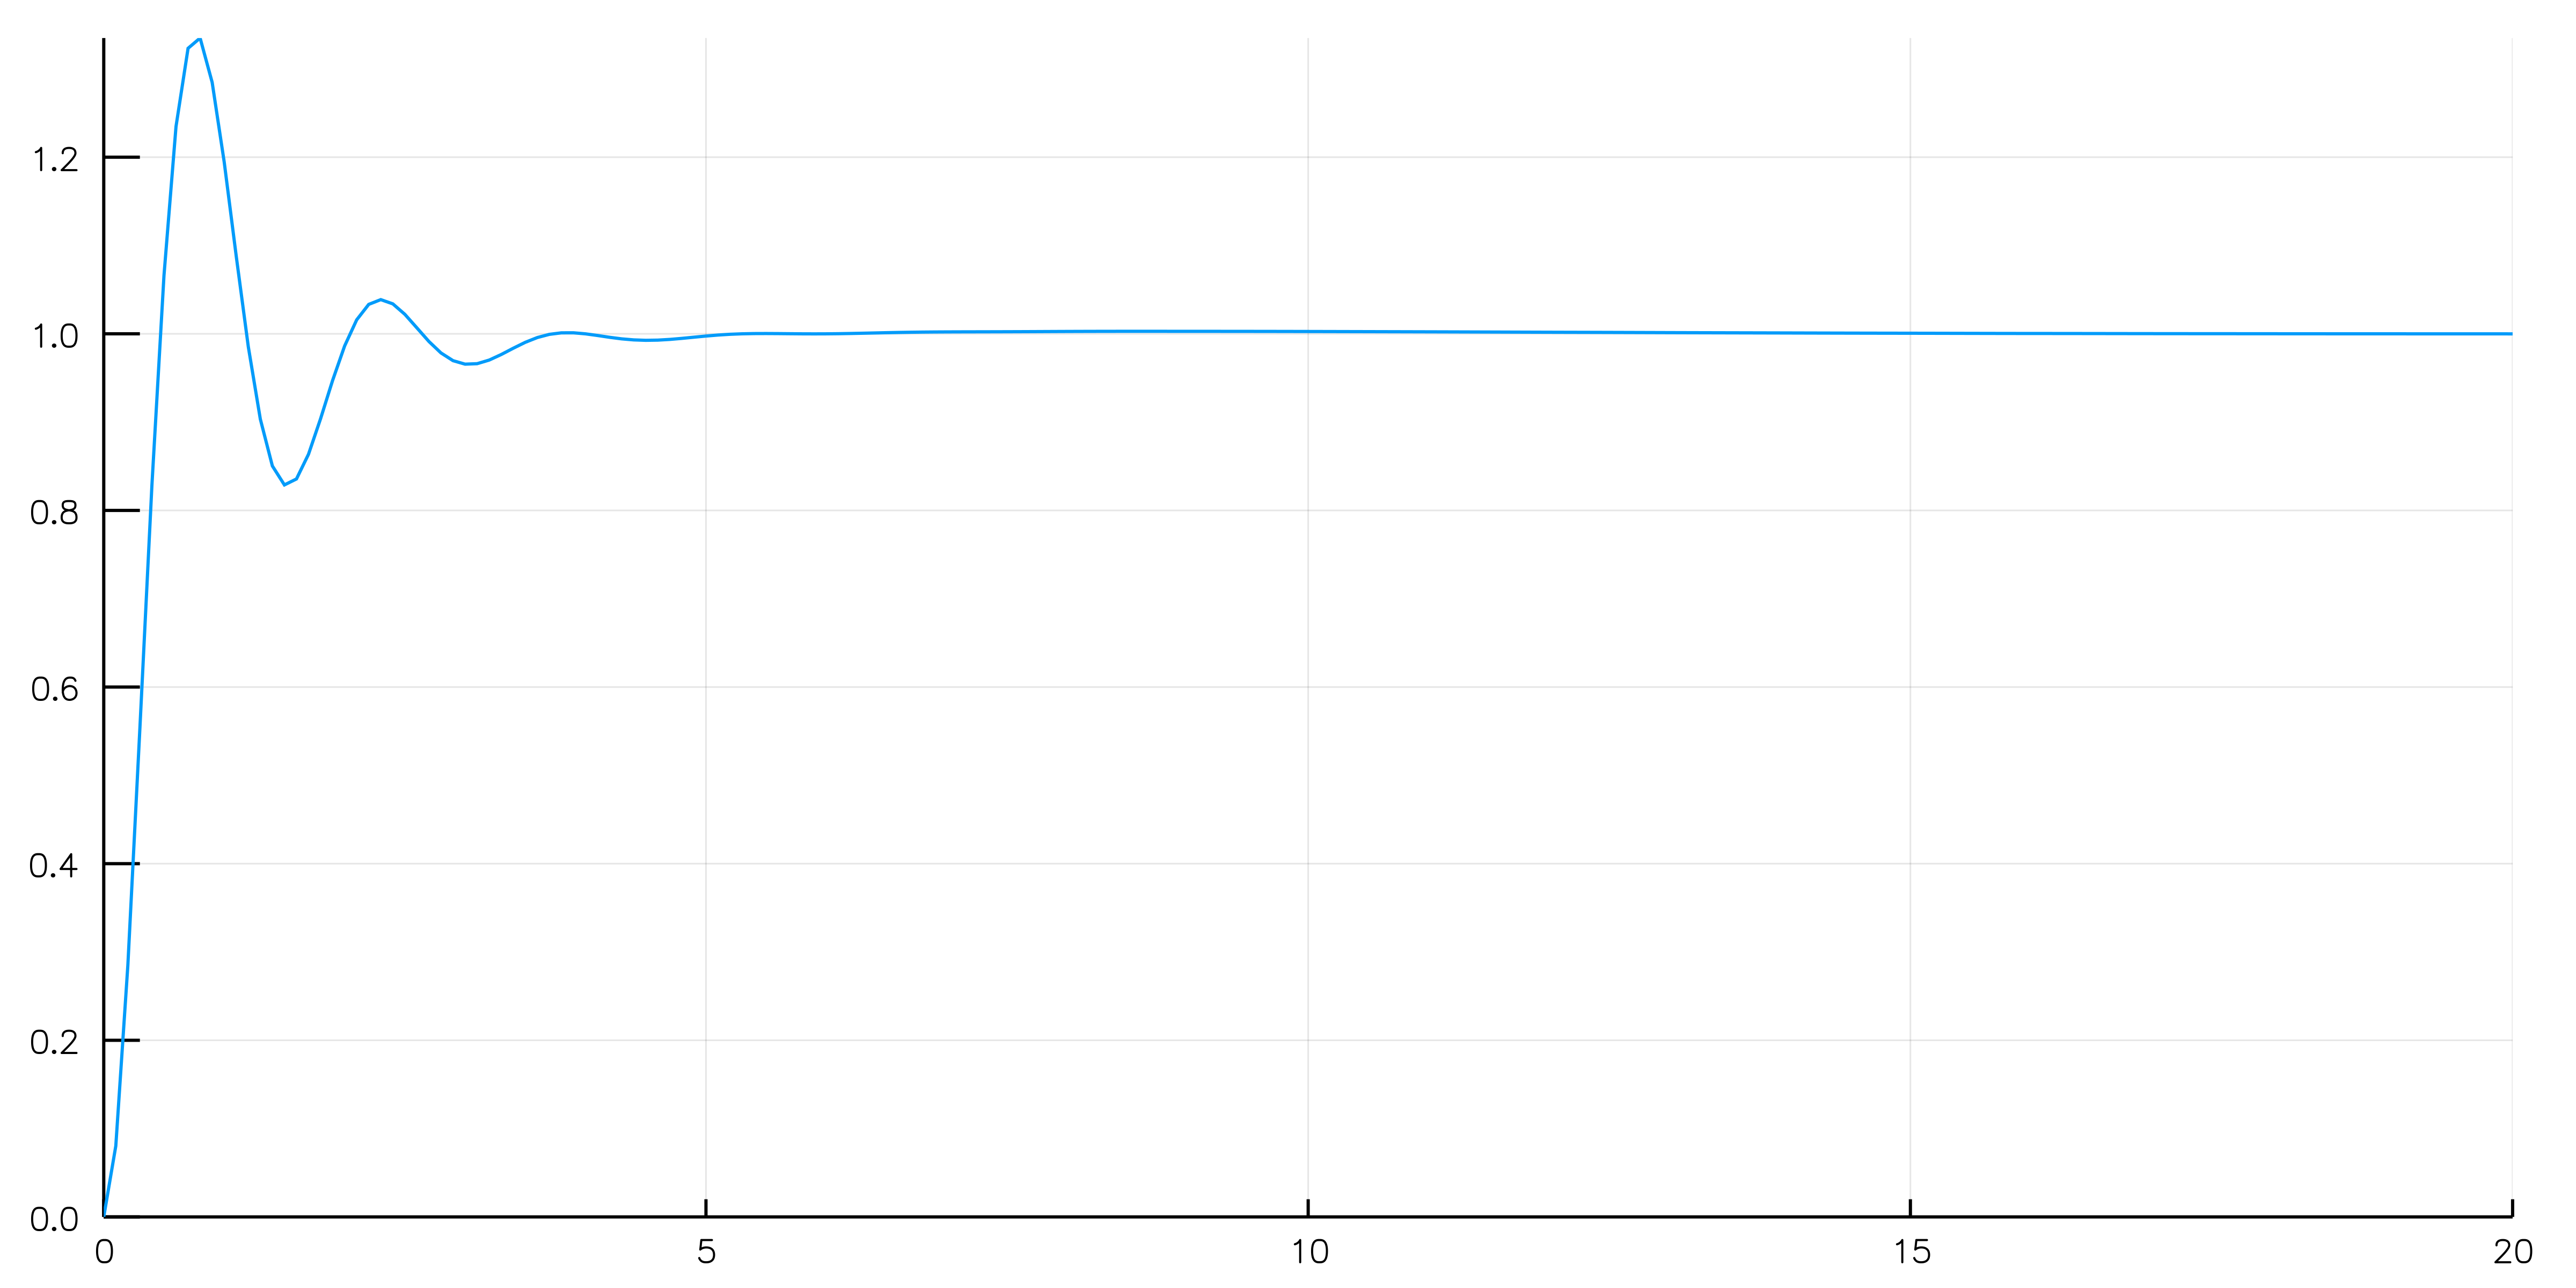

In [4]:
using NLopt, ForwardDiff
p           = [0.1, 0.1, 0.1] # Initial guess [kp, ki, kd]
K(kp,ki,kd) = pid(kp=kp, ki=ki, kd=kd)
K(p)        = K(p...)

function timedomain(p)
    C     = K(p[1], p[2], p[3])
    L     = feedback(P,C) |> ss
    s     = Simulator(L, (t,x) -> [1]) # Sim. unit step load disturbance
    ty    = eltype(p) # So that all inputs to solve have same numerical type (ForwardDiff.Dual)
    x0    = zeros(L.nx) .|> ty
    tspan = (ty(0.),ty(Tf))
    sol   = solve(s, x0, tspan)
    y     = L.C*sol(t) # y = C*x
    y
end

function costfun(p)
    y = timedomain(p)
    mean(abs,1.-y) # ~ Integrated absolute error IAE
end

f_cfg = ForwardDiff.GradientConfig(costfun, p)

function f(p::Vector, grad::Vector)
    if length(grad) > 0
        grad .= ForwardDiff.gradient(costfun,p,f_cfg)
    end
    costfun(p)
end

function runopt(p; f_tol = 1e-5, x_tol = 1e-3)
    opt = Opt(:LD_AUGLAG, 3)
    lower_bounds!(opt, 1e-6ones(3))
    xtol_rel!(opt, x_tol)
    ftol_rel!(opt, f_tol)

    min_objective!(opt, f)
    NLopt.optimize(opt, p)[2]
end


@time p = runopt(p, x_tol=1e-6)
y = timedomain(p)
plot(t,y', show=false)

If we look at the sensitivity function of the closed-loop system obtained with the optimized controller, we see that the optimization procedure produced a quite aggressive controller with poor robustness. 

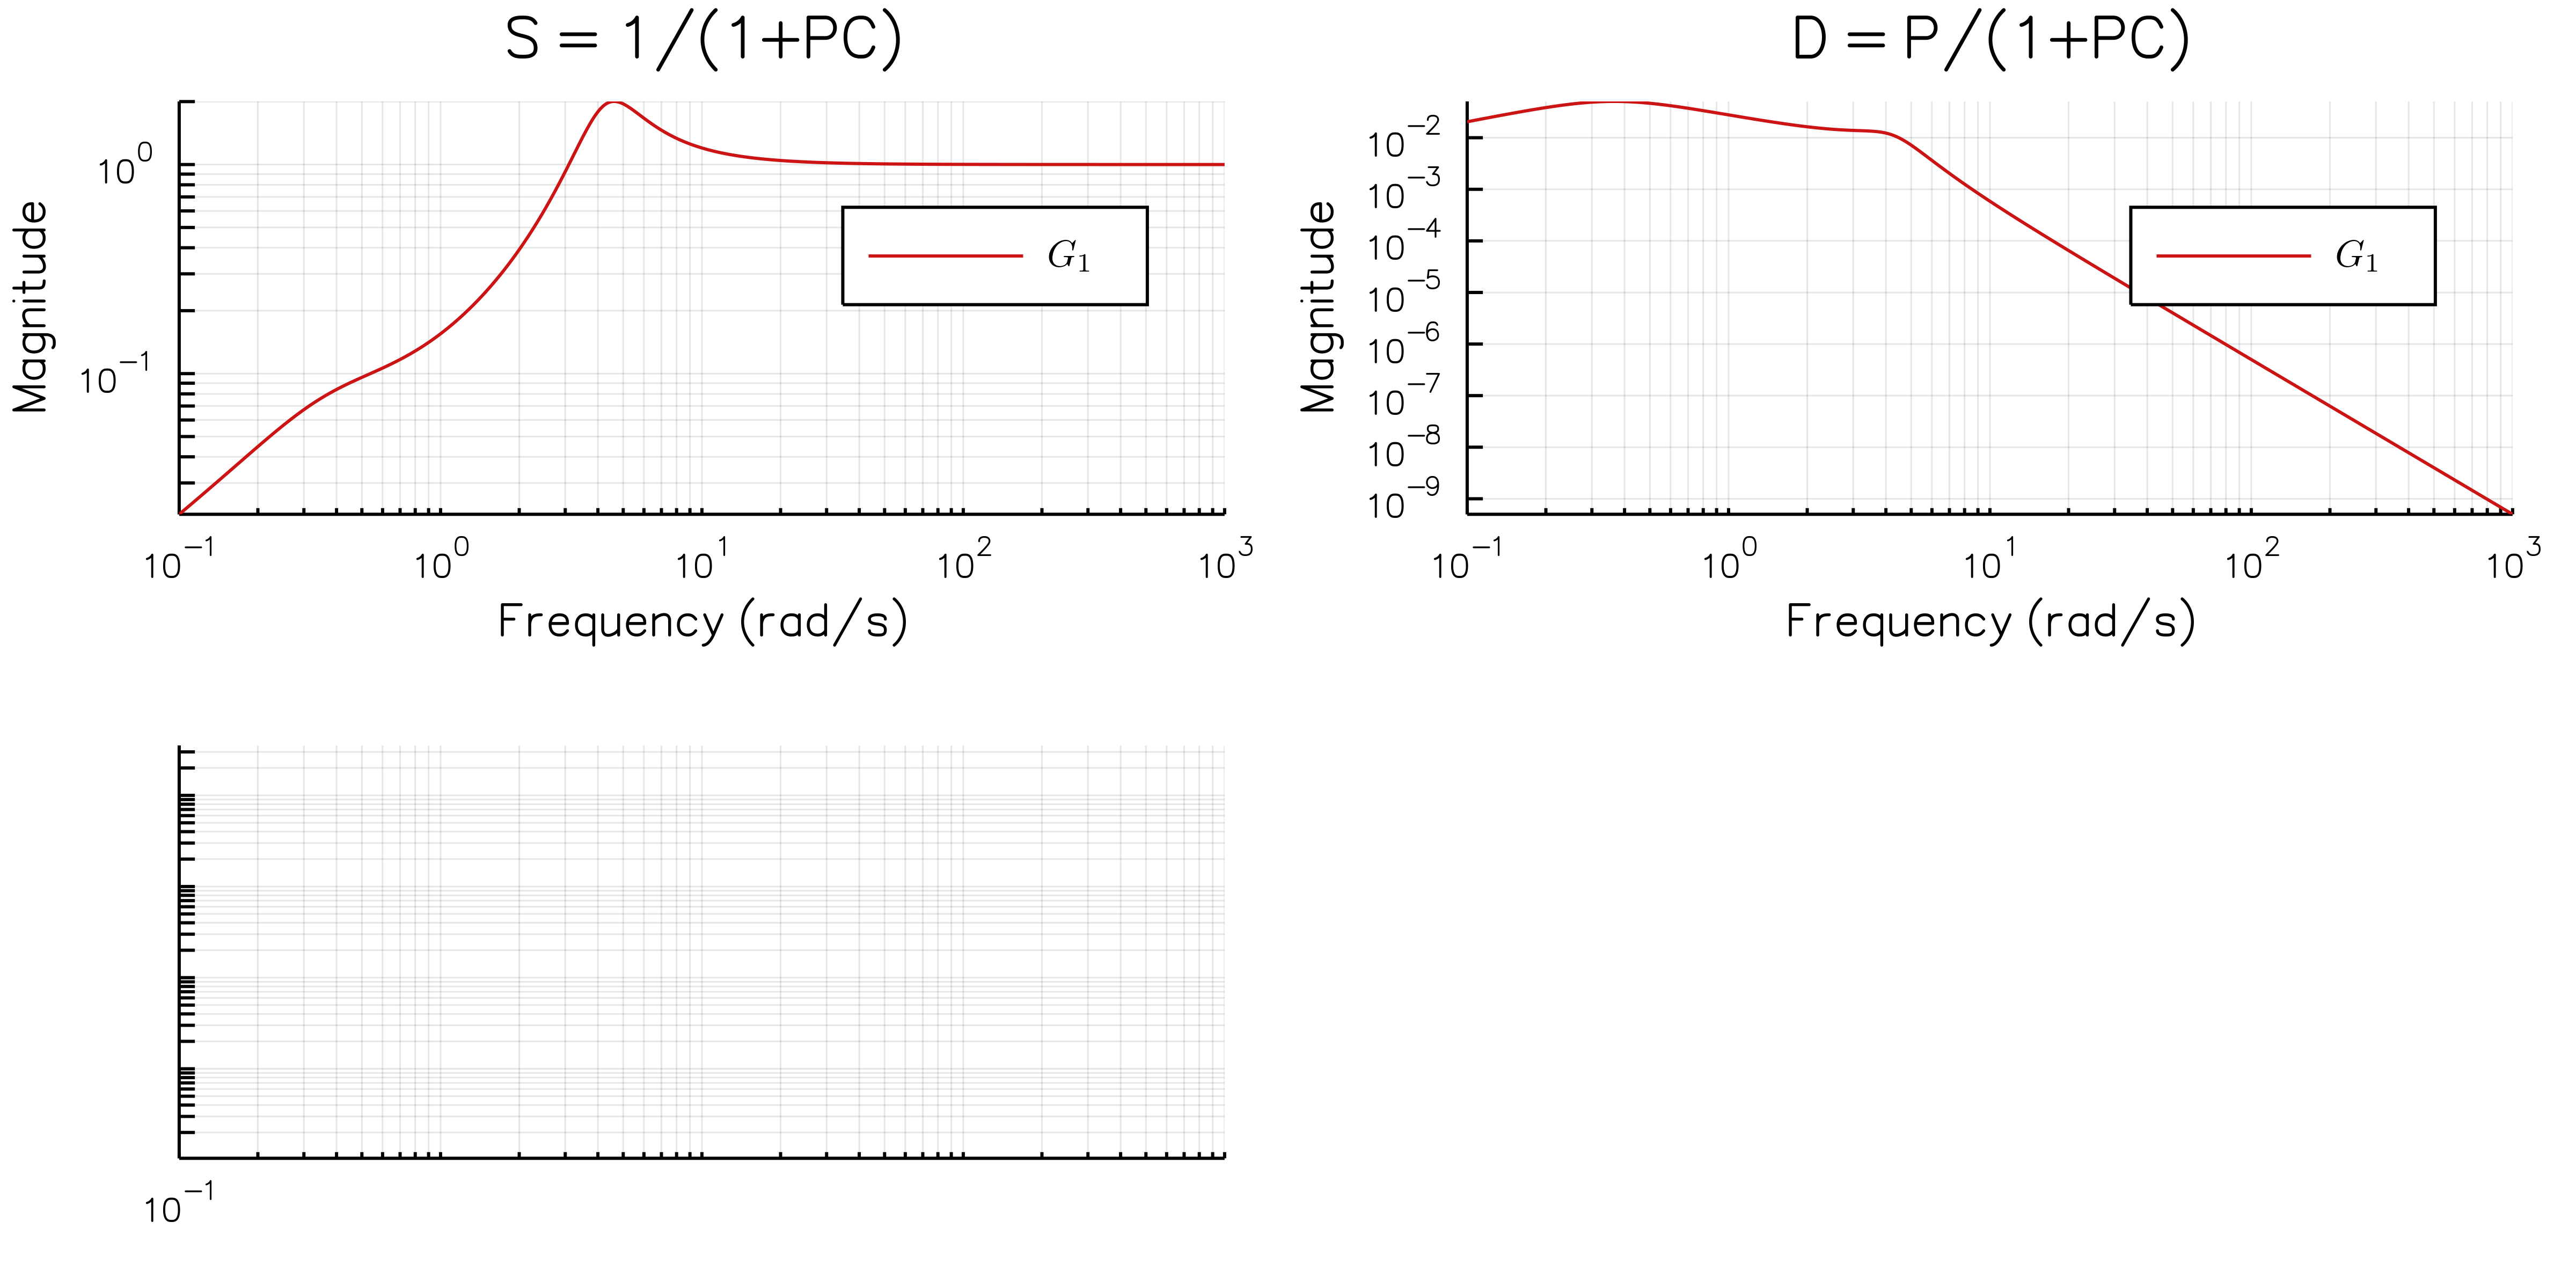

In [55]:
C     = K(p[1], p[2], p[3])
gangoffourplot(P,C, logspace(-1,3,500))

To combat this, we can add bounds on the maximum value of the sensitivity functions:

In [8]:
Ω  = logspace(-1,2,150)
p0 = [0.1,0.1,0.1]
function freqdomain(p)
    C     = K(p[1], p[2], p[3])
    S     = 1/(1+P*C) # Sensitivity fun
    T     = tf(1.) - S# Comp. Sensitivity fun
    Sw    = vec(bode(S,Ω)[1]) # Freq. domain constraints
    Tw    = vec(bode(T,Ω)[1]) # Freq. domain constraints
    Sw,Tw
end
Mt = 1.5
@manipulate for Ms = linspace(1.1,2,20)
    global p0
    p = p0
    function constraintfun(p)
        Sw,Tw = freqdomain(p)
        [maximum(Sw)-Ms; maximum(Tw)-Mt]
    end

    g_cfg = ForwardDiff.JacobianConfig(constraintfun, p)

    function c(result, p::Vector, grad)
        if length(grad) > 0
            grad .= ForwardDiff.jacobian(constraintfun,p,g_cfg)'
        end
        result .= constraintfun(p)
    end

    function runopt(p; f_tol = 1e-5, x_tol = 1e-3, c_tol = 1e-8)
        opt = Opt(:LD_SLSQP, 3)
        lower_bounds!(opt, 1e-6ones(3))
        xtol_rel!(opt, x_tol)
        ftol_rel!(opt, f_tol)

        min_objective!(opt, f)
        inequality_constraint!(opt, c, c_tol*ones(2))
        NLopt.optimize(opt, p)[2]
    end


    p = runopt(p, x_tol=1e-6)
    y = timedomain(p)
    Sw,Tw = freqdomain(p)
    plot(t,y', layout=2, show=false)
    plot!(Ω, [Sw Tw] , lab=["Sw" "Tw"], subplot=2, xscale=:log10, yscale=:log10, show=false, ylims=(0.,1.5))
    plot!([Ω[1],Ω[end]], [Ms,Ms], c = :black, l=:dash, subplot=2, show=false, lab="Ms")
    plot!([Ω[1],Ω[end]], [Mt,Mt], c = :purple, l=:dash, subplot=2, lab="Mt", ylims=(0.01,3))
end

(div
  (div)
  (WebIO.Widget("context-14", Channel{Any}(sz_max:32,sz_curr:0), Dict{String,Tuple{Observables.Observable,Union{Bool, Void}}}(Pair{String,Tuple{Observables.Observable,Union{Bool, Void}}}("obs-output", (Observables.Observable{String}("ob_12", "<?xml version=\"1.0\" encoding=\"utf-8\"?>\n<svg xmlns=\"http://www.w3.org/2000/svg\" xmlns:xlink=\"http://www.w3.org/1999/xlink\" width=\"800\" height=\"400\" viewBox=\"0 0 800 400\">\n<defs>\n  <clipPath id=\"clip00\">\n    <rect x=\"0\" y=\"0\" width=\"800\" height=\"400\"/>\n  </clipPath>\n</defs>\n<polygon clip-path=\"url(#clip0000)\" points=\"\n0,400 800,400 800,0 0,0 \n  \" fill=\"#ffffff\" fill-opacity=\"1\"/>\n<defs>\n  <clipPath id=\"clip01\">\n    <rect x=\"160\" y=\"0\" width=\"561\" height=\"400\"/>\n  </clipPath>\n</defs>\n<polygon clip-path=\"url(#clip0000)\" points=\"\n38.8117,377.923 370.78,377.923 370.78,11.811 38.8117,11.811 \n  \" fill=\"#ffffff\" fill-opacity=\"1\"/>\n<defs>\n  <clipPath id=\"clip02\">\n    <rect x=\"38\" y=\"11\" width=\"333\" height=\"367\"/>\n  </clipPath>\n</defs>\n<polyline clip-path=\"url(#clip0002)\" style=\"stroke:#000000; stroke-width:0.5; stroke-opacity:0.1; fill:none\" points=\"\n  38.8117,377.923 38.8117,11.811 \n  \"/>\n<polyline clip-path=\"url(#clip0002)\" style=\"stroke:#000000; stroke-width:0.5; stroke-opacity:0.1; fill:none\" points=\"\n  121.804,377.923 121.804,11.811 \n  \"/>\n<polyline clip-path=\"url(#clip0002)\" style=\"stroke:#000000; stroke-width:0.5; stroke-opacity:0.1; fill:none\" points=\"\n  204.796,377.923 204.796,11.811 \n  \"/>\n<polyline clip-path=\"url(#clip0002)\" style=\"stroke:#000000; stroke-width:0.5; stroke-opacity:0.1; fill:none\" points=\"\n  287.788,377.923 287.788,11.811 \n  \"/>\n<polyline clip-path=\"url(#clip0002)\" style=\"stroke:#000000; stroke-width:0.5; stroke-opacity:0.1; fill:none\" points=\"\n  370.78,377.923 370.78,11.811 \n  \"/>\n<polyline clip-path=\"url(#clip0002)\" style=\"stroke:#000000; stroke-width:0.5; stroke-opacity:0.1; fill:none\" points=\"\n  38.8117,377.923 370.78,377.923 \n  \"/>\n<polyline clip-path=\"url(#clip0002)\" style=\"stroke:#000000; stroke-width:0.5; stroke-opacity:0.1; fill:none\" points=\"\n  38.8117,299.508 370.78,299.508 \n  \"/>\n<polyline clip-path=\"url(#clip0002)\" style=\"stroke:#000000; stroke-width:0.5; stroke-opacity:0.1; fill:none\" points=\"\n  38.8117,221.093 370.78,221.093 \n  \"/>\n<polyline clip-path=\"url(#clip0002)\" style=\"stroke:#000000; stroke-width:0.5; stroke-opacity:0.1; fill:none\" points=\"\n  38.8117,142.678 370.78,142.678 \n  \"/>\n<polyline clip-path=\"url(#clip0002)\" style=\"stroke:#000000; stroke-width:0.5; stroke-opacity:0.1; fill:none\" points=\"\n  38.8117,64.2636 370.78,64.2636 \n  \"/>\n<polyline clip-path=\"url(#clip0000)\" style=\"stroke:#000000; stroke-width:1; stroke-opacity:1; fill:none\" points=\"\n  38.8117,377.923 370.78,377.923 \n  \"/>\n<polyline clip-path=\"url(#clip0000)\" style=\"stroke:#000000; stroke-width:1; stroke-opacity:1; fill:none\" points=\"\n  38.8117,377.923 38.8117,11.811 \n  \"/>\n<polyline clip-path=\"url(#clip0000)\" style=\"stroke:#000000; stroke-width:1; stroke-opacity:1; fill:none\" points=\"\n  38.8117,377.923 38.8117,372.431 \n  \"/>\n<polyline clip-path=\"url(#clip0000)\" style=\"stroke:#000000; stroke-width:1; stroke-opacity:1; fill:none\" points=\"\n  121.804,377.923 121.804,372.431 \n  \"/>\n<polyline clip-path=\"url(#clip0000)\" style=\"stroke:#000000; stroke-width:1; stroke-opacity:1; fill:none\" points=\"\n  204.796,377.923 204.796,372.431 \n  \"/>\n<polyline clip-path=\"url(#clip0000)\" style=\"stroke:#000000; stroke-width:1; stroke-opacity:1; fill:none\" points=\"\n  287.788,377.923 287.788,372.431 \n  \"/>\n<polyline clip-path=\"url(#clip0000)\" style=\"stroke:#000000; stroke-width:1; stroke-opacity:1; fill:none\" points=\"\n  370.78,377.923 370.78,372.431 \n  \"/>\n<polyline clip-path=\"url(#clip0000)\" style=\"stroke:#000000; stroke-width:1; stroke-opacity:1; fill:none\" point

- Does introduction of a penalty on the maximum sensitivity make the controller more robust?

## Gain Scheduling 

We now introduce gain scheduling. The following code defines two controllers and a vector of conditions that determine when to switch between the controllers. The switching conditions are allowed to be arbitrary functions of the state $x$, the output $y$ or the reference $r$. The template below implements a schedule based on a simple threshold value on the output, $y=th$. Experiment with the controller parameters of the two controllers and the scheduling signal. Anser the following questions
- Which signal is best for scheduling?
- Can you implement a controller which is both faster and has better damping than your best controller from the previous task?

Interact.Options{:SelectionSlider,Any}(179: "input-79" = 9.795918367346939 Any , "kp1", 9.795918367346939, "9.795918367346939", 25, Interact.OptionDict(DataStructures.OrderedDict{Any,Any}("0.0"=>0.0,"0.40816326530612246"=>0.408163,"0.8163265306122449"=>0.816327,"1.2244897959183674"=>1.22449,"1.6326530612244898"=>1.63265,"2.0408163265306123"=>2.04082,"2.4489795918367347"=>2.44898,"2.857142857142857"=>2.85714,"3.2653061224489797"=>3.26531,"3.673469387755102"=>3.67347…), Dict{Any,Any}(Pair{Any,Any}(9.38776, "9.387755102040817"),Pair{Any,Any}(8.57143, "8.571428571428571"),Pair{Any,Any}(1.22449, "1.2244897959183674"),Pair{Any,Any}(1.63265, "1.6326530612244898"),Pair{Any,Any}(6.93878, "6.938775510204081"),Pair{Any,Any}(12.6531, "12.653061224489797"),Pair{Any,Any}(19.5918, "19.591836734693878"),Pair{Any,Any}(18.3673, "18.367346938775512"),Pair{Any,Any}(20.0, "20.0"),Pair{Any,Any}(3.67347, "3.673469387755102")…)), Any[], Any[], true, "horizontal")

Interact.Options{:SelectionSlider,Any}(181: "input-80" = 2.4489795918367347 Any , "ki1", 2.4489795918367347, "2.4489795918367347", 25, Interact.OptionDict(DataStructures.OrderedDict{Any,Any}("0.0"=>0.0,"0.10204081632653061"=>0.102041,"0.20408163265306123"=>0.204082,"0.30612244897959184"=>0.306122,"0.40816326530612246"=>0.408163,"0.5102040816326531"=>0.510204,"0.6122448979591837"=>0.612245,"0.7142857142857143"=>0.714286,"0.8163265306122449"=>0.816327,"0.9183673469387755"=>0.918367…), Dict{Any,Any}(Pair{Any,Any}(1.22449, "1.2244897959183674"),Pair{Any,Any}(1.63265, "1.6326530612244898"),Pair{Any,Any}(4.79592, "4.795918367346939"),Pair{Any,Any}(2.14286, "2.142857142857143"),Pair{Any,Any}(3.77551, "3.7755102040816326"),Pair{Any,Any}(3.67347, "3.673469387755102"),Pair{Any,Any}(2.04082, "2.0408163265306123"),Pair{Any,Any}(0.612245, "0.6122448979591837"),Pair{Any,Any}(3.87755, "3.877551020408163"),Pair{Any,Any}(1.12245, "1.1224489795918366")…)), Any[], Any[], true, "horizontal")

Interact.Options{:SelectionSlider,Any}(183: "input-81" = 9.795918367346939 Any , "kp2", 9.795918367346939, "9.795918367346939", 25, Interact.OptionDict(DataStructures.OrderedDict{Any,Any}("0.0"=>0.0,"0.40816326530612246"=>0.408163,"0.8163265306122449"=>0.816327,"1.2244897959183674"=>1.22449,"1.6326530612244898"=>1.63265,"2.0408163265306123"=>2.04082,"2.4489795918367347"=>2.44898,"2.857142857142857"=>2.85714,"3.2653061224489797"=>3.26531,"3.673469387755102"=>3.67347…), Dict{Any,Any}(Pair{Any,Any}(9.38776, "9.387755102040817"),Pair{Any,Any}(8.57143, "8.571428571428571"),Pair{Any,Any}(1.22449, "1.2244897959183674"),Pair{Any,Any}(1.63265, "1.6326530612244898"),Pair{Any,Any}(6.93878, "6.938775510204081"),Pair{Any,Any}(12.6531, "12.653061224489797"),Pair{Any,Any}(19.5918, "19.591836734693878"),Pair{Any,Any}(18.3673, "18.367346938775512"),Pair{Any,Any}(20.0, "20.0"),Pair{Any,Any}(3.67347, "3.673469387755102")…)), Any[], Any[], true, "horizontal")

Interact.Options{:SelectionSlider,Any}(185: "input-82" = 2.4489795918367347 Any , "ki2", 2.4489795918367347, "2.4489795918367347", 25, Interact.OptionDict(DataStructures.OrderedDict{Any,Any}("0.0"=>0.0,"0.10204081632653061"=>0.102041,"0.20408163265306123"=>0.204082,"0.30612244897959184"=>0.306122,"0.40816326530612246"=>0.408163,"0.5102040816326531"=>0.510204,"0.6122448979591837"=>0.612245,"0.7142857142857143"=>0.714286,"0.8163265306122449"=>0.816327,"0.9183673469387755"=>0.918367…), Dict{Any,Any}(Pair{Any,Any}(1.22449, "1.2244897959183674"),Pair{Any,Any}(1.63265, "1.6326530612244898"),Pair{Any,Any}(4.79592, "4.795918367346939"),Pair{Any,Any}(2.14286, "2.142857142857143"),Pair{Any,Any}(3.77551, "3.7755102040816326"),Pair{Any,Any}(3.67347, "3.673469387755102"),Pair{Any,Any}(2.04082, "2.0408163265306123"),Pair{Any,Any}(0.612245, "0.6122448979591837"),Pair{Any,Any}(3.87755, "3.877551020408163"),Pair{Any,Any}(1.12245, "1.1224489795918366")…)), Any[], Any[], true, "horizontal")

Interact.Options{:SelectionSlider,Any}(187: "input-83" = 9.795918367346939 Any , "kd", 9.795918367346939, "9.795918367346939", 25, Interact.OptionDict(DataStructures.OrderedDict{Any,Any}("0.0"=>0.0,"0.40816326530612246"=>0.408163,"0.8163265306122449"=>0.816327,"1.2244897959183674"=>1.22449,"1.6326530612244898"=>1.63265,"2.0408163265306123"=>2.04082,"2.4489795918367347"=>2.44898,"2.857142857142857"=>2.85714,"3.2653061224489797"=>3.26531,"3.673469387755102"=>3.67347…), Dict{Any,Any}(Pair{Any,Any}(9.38776, "9.387755102040817"),Pair{Any,Any}(8.57143, "8.571428571428571"),Pair{Any,Any}(1.22449, "1.2244897959183674"),Pair{Any,Any}(1.63265, "1.6326530612244898"),Pair{Any,Any}(6.93878, "6.938775510204081"),Pair{Any,Any}(12.6531, "12.653061224489797"),Pair{Any,Any}(19.5918, "19.591836734693878"),Pair{Any,Any}(18.3673, "18.367346938775512"),Pair{Any,Any}(20.0, "20.0"),Pair{Any,Any}(3.67347, "3.673469387755102")…)), Any[], Any[], true, "horizontal")

Interact.Options{:SelectionSlider,Any}(189: "input-84" = 0.47368421052631576 Any , "th", 0.47368421052631576, "0.47368421052631576", 10, Interact.OptionDict(DataStructures.OrderedDict{Any,Any}("0.0"=>0.0,"0.05263157894736842"=>0.0526316,"0.10526315789473684"=>0.105263,"0.15789473684210525"=>0.157895,"0.21052631578947367"=>0.210526,"0.2631578947368421"=>0.263158,"0.3157894736842105"=>0.315789,"0.3684210526315789"=>0.368421,"0.42105263157894735"=>0.421053,"0.47368421052631576"=>0.473684…), Dict{Any,Any}(Pair{Any,Any}(1.0, "1.0"),Pair{Any,Any}(0.0526316, "0.05263157894736842"),Pair{Any,Any}(0.947368, "0.9473684210526315"),Pair{Any,Any}(0.789474, "0.7894736842105263"),Pair{Any,Any}(0.0, "0.0"),Pair{Any,Any}(0.368421, "0.3684210526315789"),Pair{Any,Any}(0.263158, "0.2631578947368421"),Pair{Any,Any}(0.894737, "0.8947368421052632"),Pair{Any,Any}(0.526316, "0.5263157894736842"),Pair{Any,Any}(0.473684, "0.47368421052631576")…)), Any[], Any[], true, "horizontal")

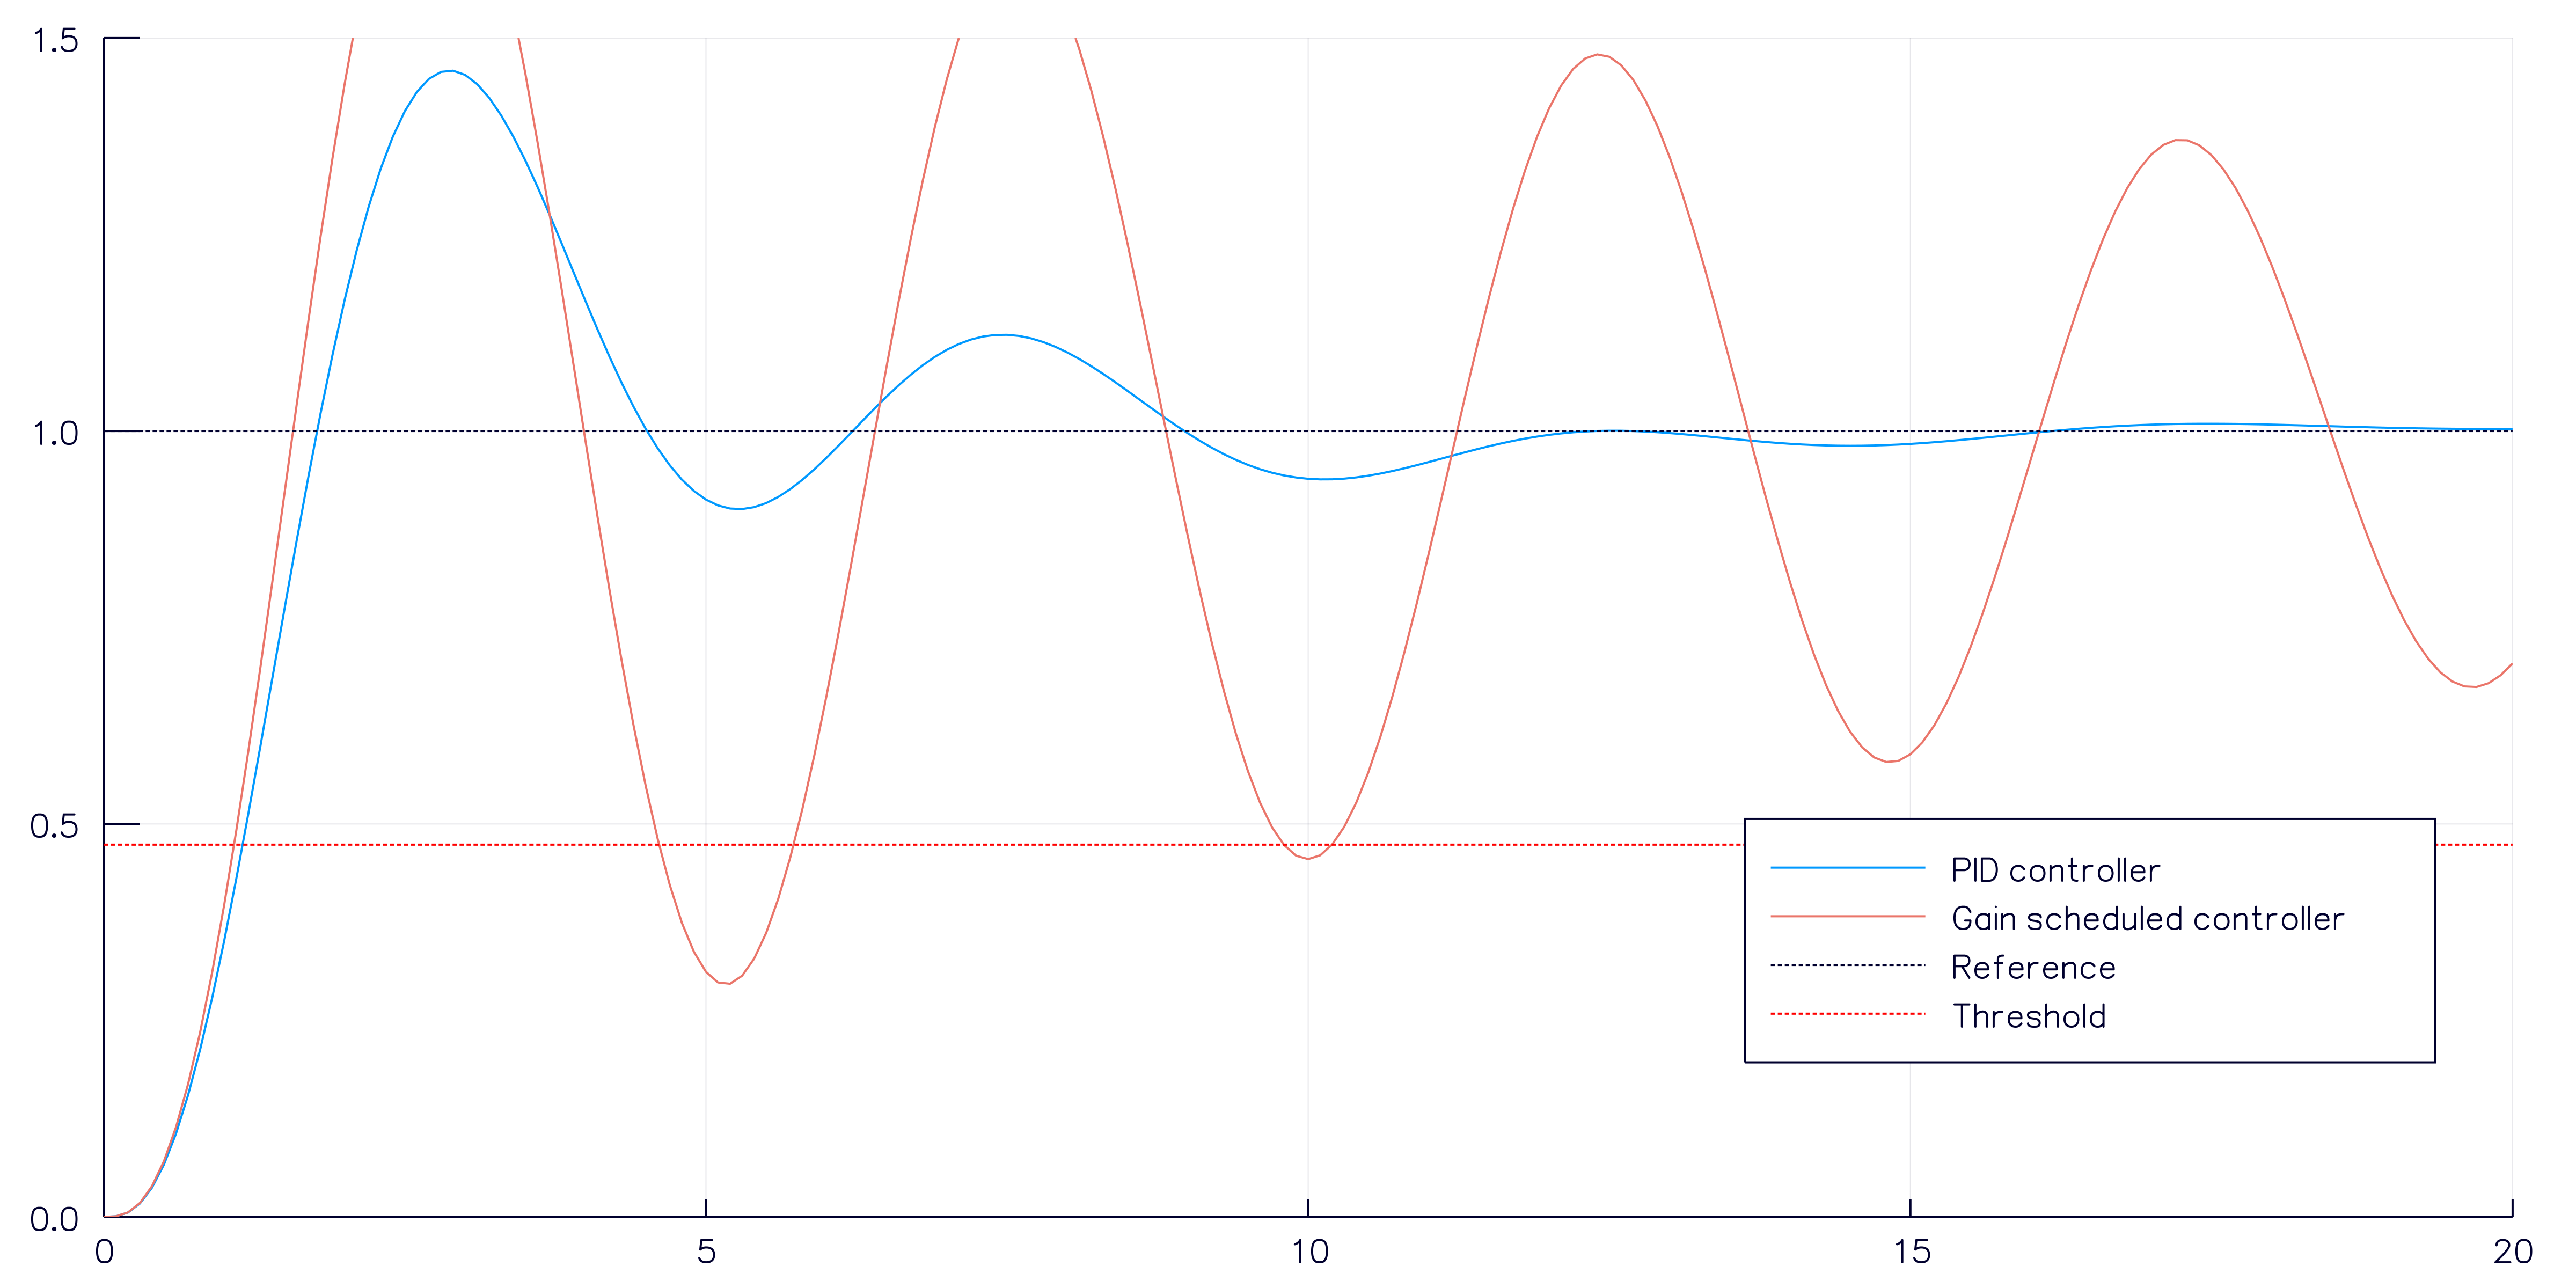

In [29]:
@manipulate for kp1 = linspace(0,20,50),ki1 = linspace(0,5,50),kp2 = linspace(0,20,50),ki2 = linspace(0,5,50),kd  = linspace(0,20,50),th  = linspace(0,1,20)
    
    global gs
    plot(t, gs.y(sol2, t)[:], lab="PID controller")

    controllers  = [pid(kp=kp1, ki=ki1, kd=kd), pid(kp=kp2, ki=ki2, kd=kd)]
    conditions   = [(x,y,r) -> y[1] < th, (x,y,r) -> y[1] >= th]
    gs2          = GainSchedulingSimulator(Ps, reference, controllers, conditions)
    sol3         = solve(gs2, x0, tspan, Tsit5())
    plot!(t, gs2.y(sol3, t)[:], lab="Gain scheduled controller", ylims=(0,1.5))
    plot!([tspan...], [1,1], lab="Reference", l=(:dash, :black))
    plot!([tspan...], [th, th], lab="Threshold", l=(:dash, :red), legend=:bottomright)
end

Okay, now it's time to make it a bit harder. We now add a nonlinearity to the process input. We can play around a bit with the type of the nonlinearity, but let's start with
$$u = u_i^2 \quad \text{if}\quad  u_i > 0$$
$$u = 0.1u_i \quad \text{otherwise}$$
depicted below.

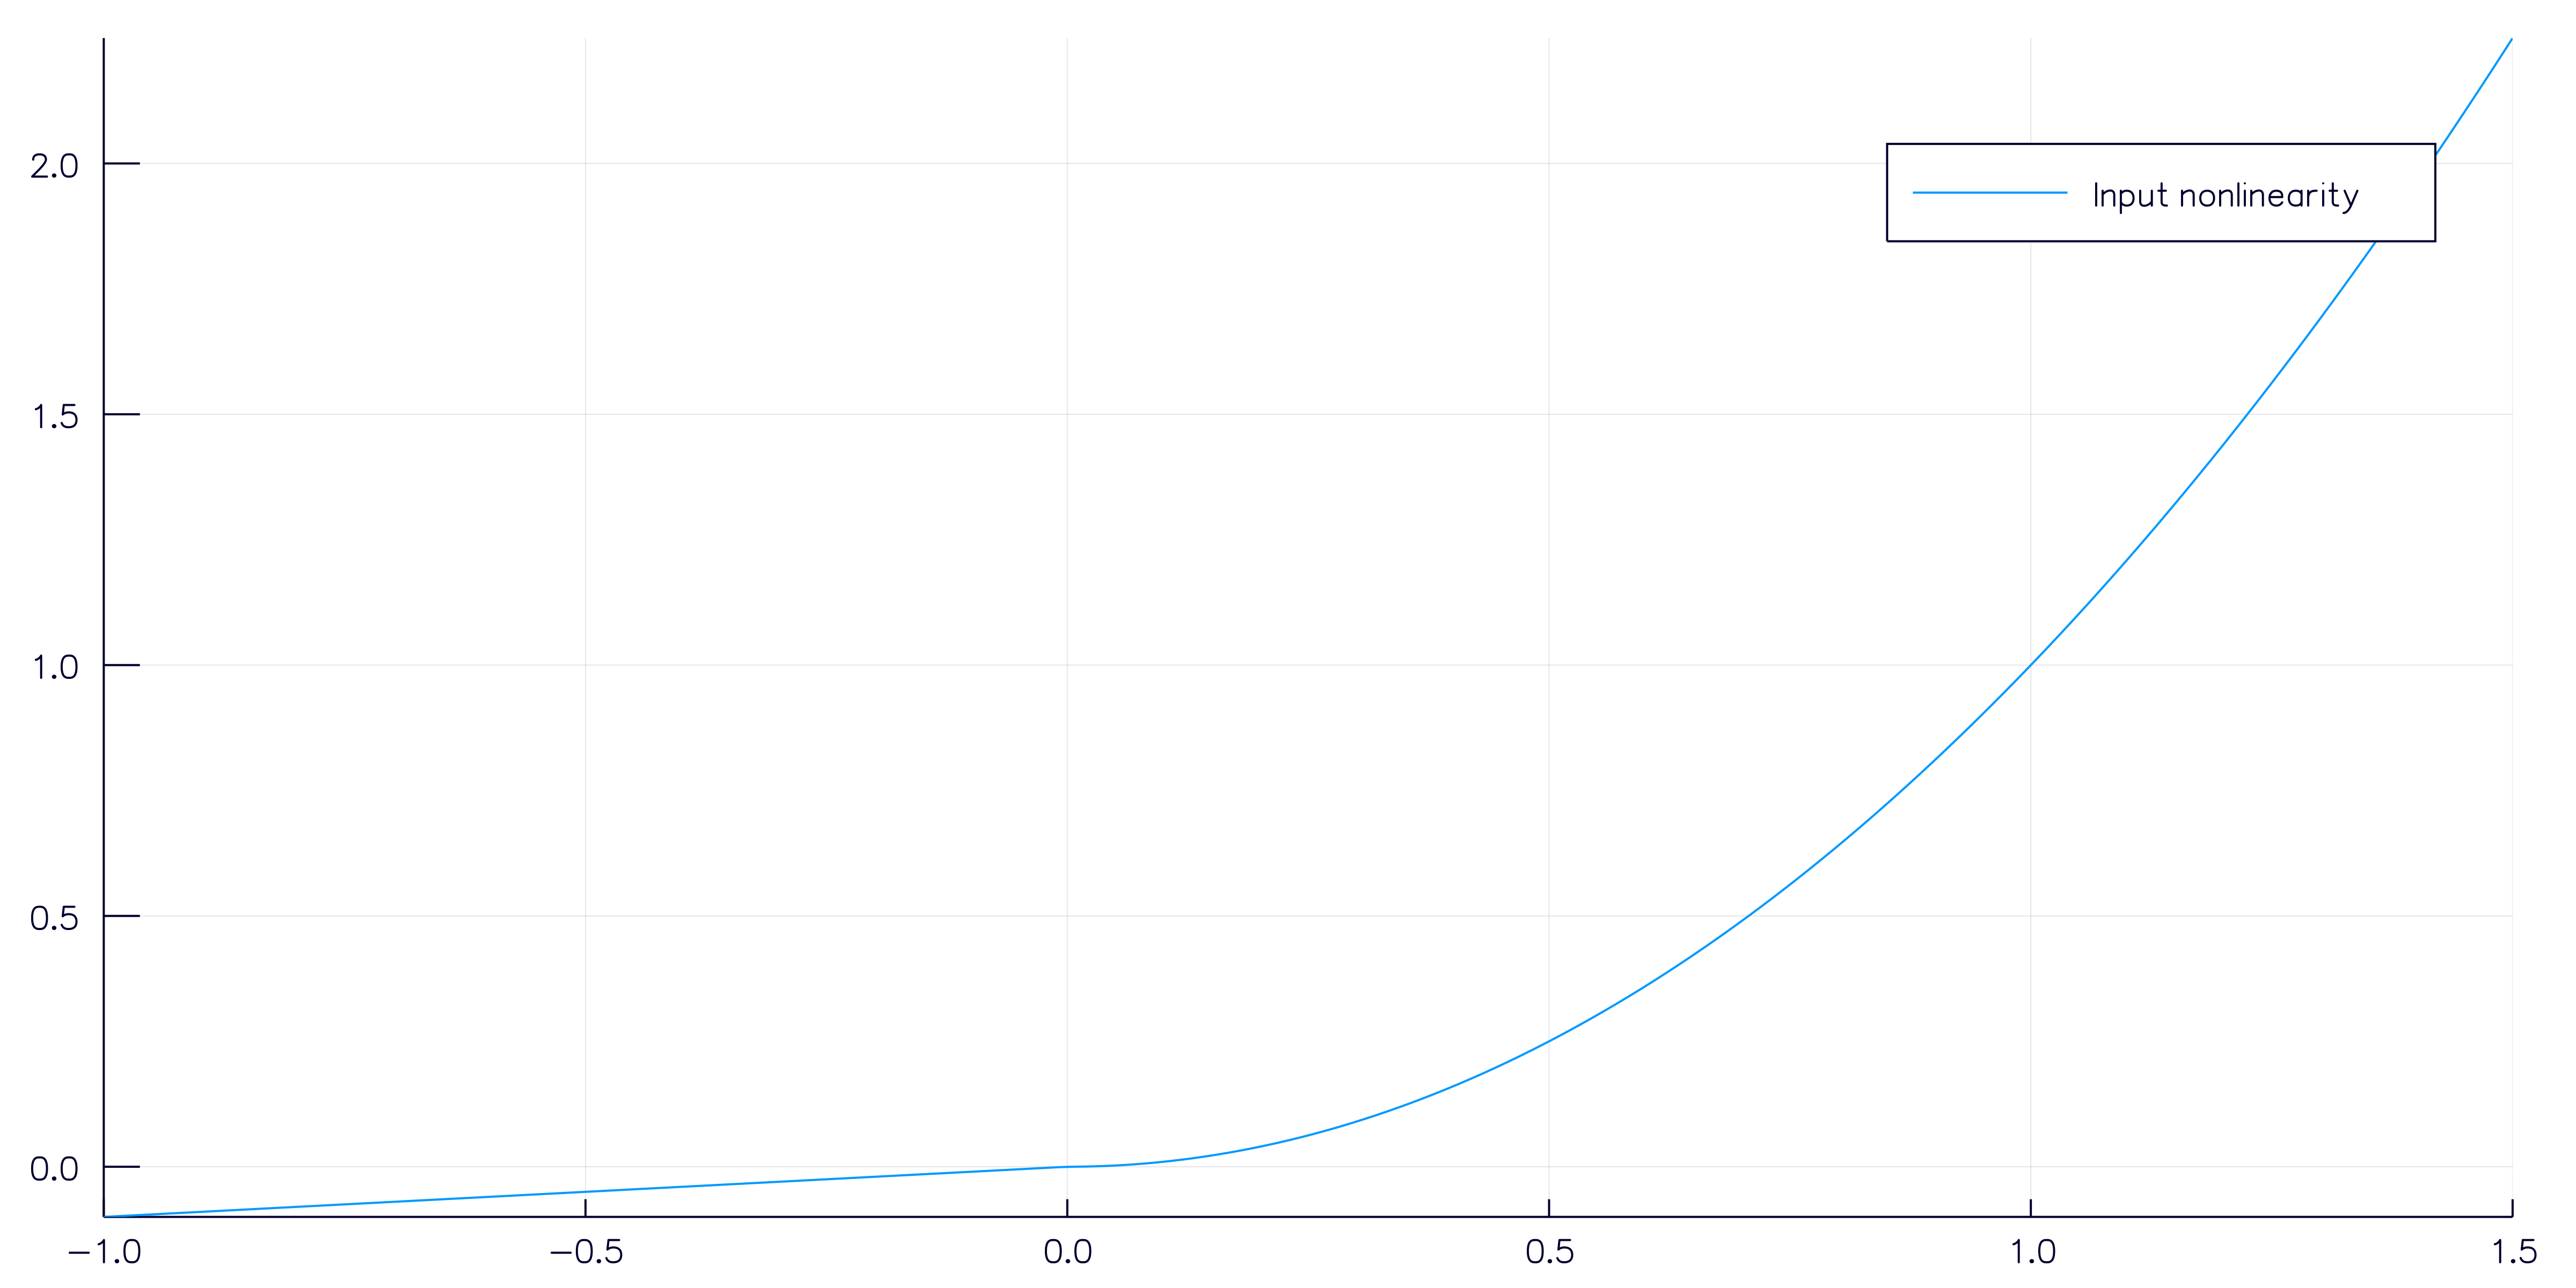

In [30]:
nonlinearity(u) = u < 0 ? 0.1u : u^2
plot(linspace(-1,1.5,200),nonlinearity,lab="Input nonlinearity")

Try tuning a P-controller for the system with the input nonlinearity. Is it possible to achieve an okay result?

Interact.Options{:SelectionSlider,Any}(193: "input-85" = 4.8979591836734695 Any , "kp", 4.8979591836734695, "4.8979591836734695", 25, Interact.OptionDict(DataStructures.OrderedDict{Any,Any}("0.0"=>0.0,"0.20408163265306123"=>0.204082,"0.40816326530612246"=>0.408163,"0.6122448979591837"=>0.612245,"0.8163265306122449"=>0.816327,"1.0204081632653061"=>1.02041,"1.2244897959183674"=>1.22449,"1.4285714285714286"=>1.42857,"1.6326530612244898"=>1.63265,"1.836734693877551"=>1.83673…), Dict{Any,Any}(Pair{Any,Any}(8.77551, "8.775510204081632"),Pair{Any,Any}(7.55102, "7.551020408163265"),Pair{Any,Any}(8.36735, "8.36734693877551"),Pair{Any,Any}(9.38776, "9.387755102040817"),Pair{Any,Any}(8.57143, "8.571428571428571"),Pair{Any,Any}(1.22449, "1.2244897959183674"),Pair{Any,Any}(1.63265, "1.6326530612244898"),Pair{Any,Any}(6.93878, "6.938775510204081"),Pair{Any,Any}(6.32653, "6.326530612244898"),Pair{Any,Any}(3.67347, "3.673469387755102")…)), Any[], Any[], true, "horizontal")

Interact.Options{:SelectionSlider,Any}(195: "input-86" = 3.9183673469387754 Any , "ki", 3.9183673469387754, "3.9183673469387754", 25, Interact.OptionDict(DataStructures.OrderedDict{Any,Any}("0.0"=>0.0,"0.16326530612244897"=>0.163265,"0.32653061224489793"=>0.326531,"0.4897959183673469"=>0.489796,"0.6530612244897959"=>0.653061,"0.8163265306122449"=>0.816327,"0.9795918367346939"=>0.979592,"1.1428571428571428"=>1.14286,"1.3061224489795917"=>1.30612,"1.469387755102041"=>1.46939…), Dict{Any,Any}(Pair{Any,Any}(3.59184, "3.5918367346938775"),Pair{Any,Any}(6.85714, "6.857142857142857"),Pair{Any,Any}(1.95918, "1.9591836734693877"),Pair{Any,Any}(8.0, "8.0"),Pair{Any,Any}(1.63265, "1.6326530612244898"),Pair{Any,Any}(6.20408, "6.204081632653061"),Pair{Any,Any}(7.67347, "7.673469387755102"),Pair{Any,Any}(2.61224, "2.6122448979591835"),Pair{Any,Any}(4.57143, "4.571428571428571"),Pair{Any,Any}(1.79592, "1.7959183673469388")…)), Any[], Any[], true, "horizontal")

Interact.Options{:SelectionSlider,Any}(197: "input-87" = 9.795918367346939 Any , "kd", 9.795918367346939, "9.795918367346939", 25, Interact.OptionDict(DataStructures.OrderedDict{Any,Any}("0.0"=>0.0,"0.40816326530612246"=>0.408163,"0.8163265306122449"=>0.816327,"1.2244897959183674"=>1.22449,"1.6326530612244898"=>1.63265,"2.0408163265306123"=>2.04082,"2.4489795918367347"=>2.44898,"2.857142857142857"=>2.85714,"3.2653061224489797"=>3.26531,"3.673469387755102"=>3.67347…), Dict{Any,Any}(Pair{Any,Any}(9.38776, "9.387755102040817"),Pair{Any,Any}(8.57143, "8.571428571428571"),Pair{Any,Any}(1.22449, "1.2244897959183674"),Pair{Any,Any}(1.63265, "1.6326530612244898"),Pair{Any,Any}(6.93878, "6.938775510204081"),Pair{Any,Any}(12.6531, "12.653061224489797"),Pair{Any,Any}(19.5918, "19.591836734693878"),Pair{Any,Any}(18.3673, "18.367346938775512"),Pair{Any,Any}(20.0, "20.0"),Pair{Any,Any}(3.67347, "3.673469387755102")…)), Any[], Any[], true, "horizontal")

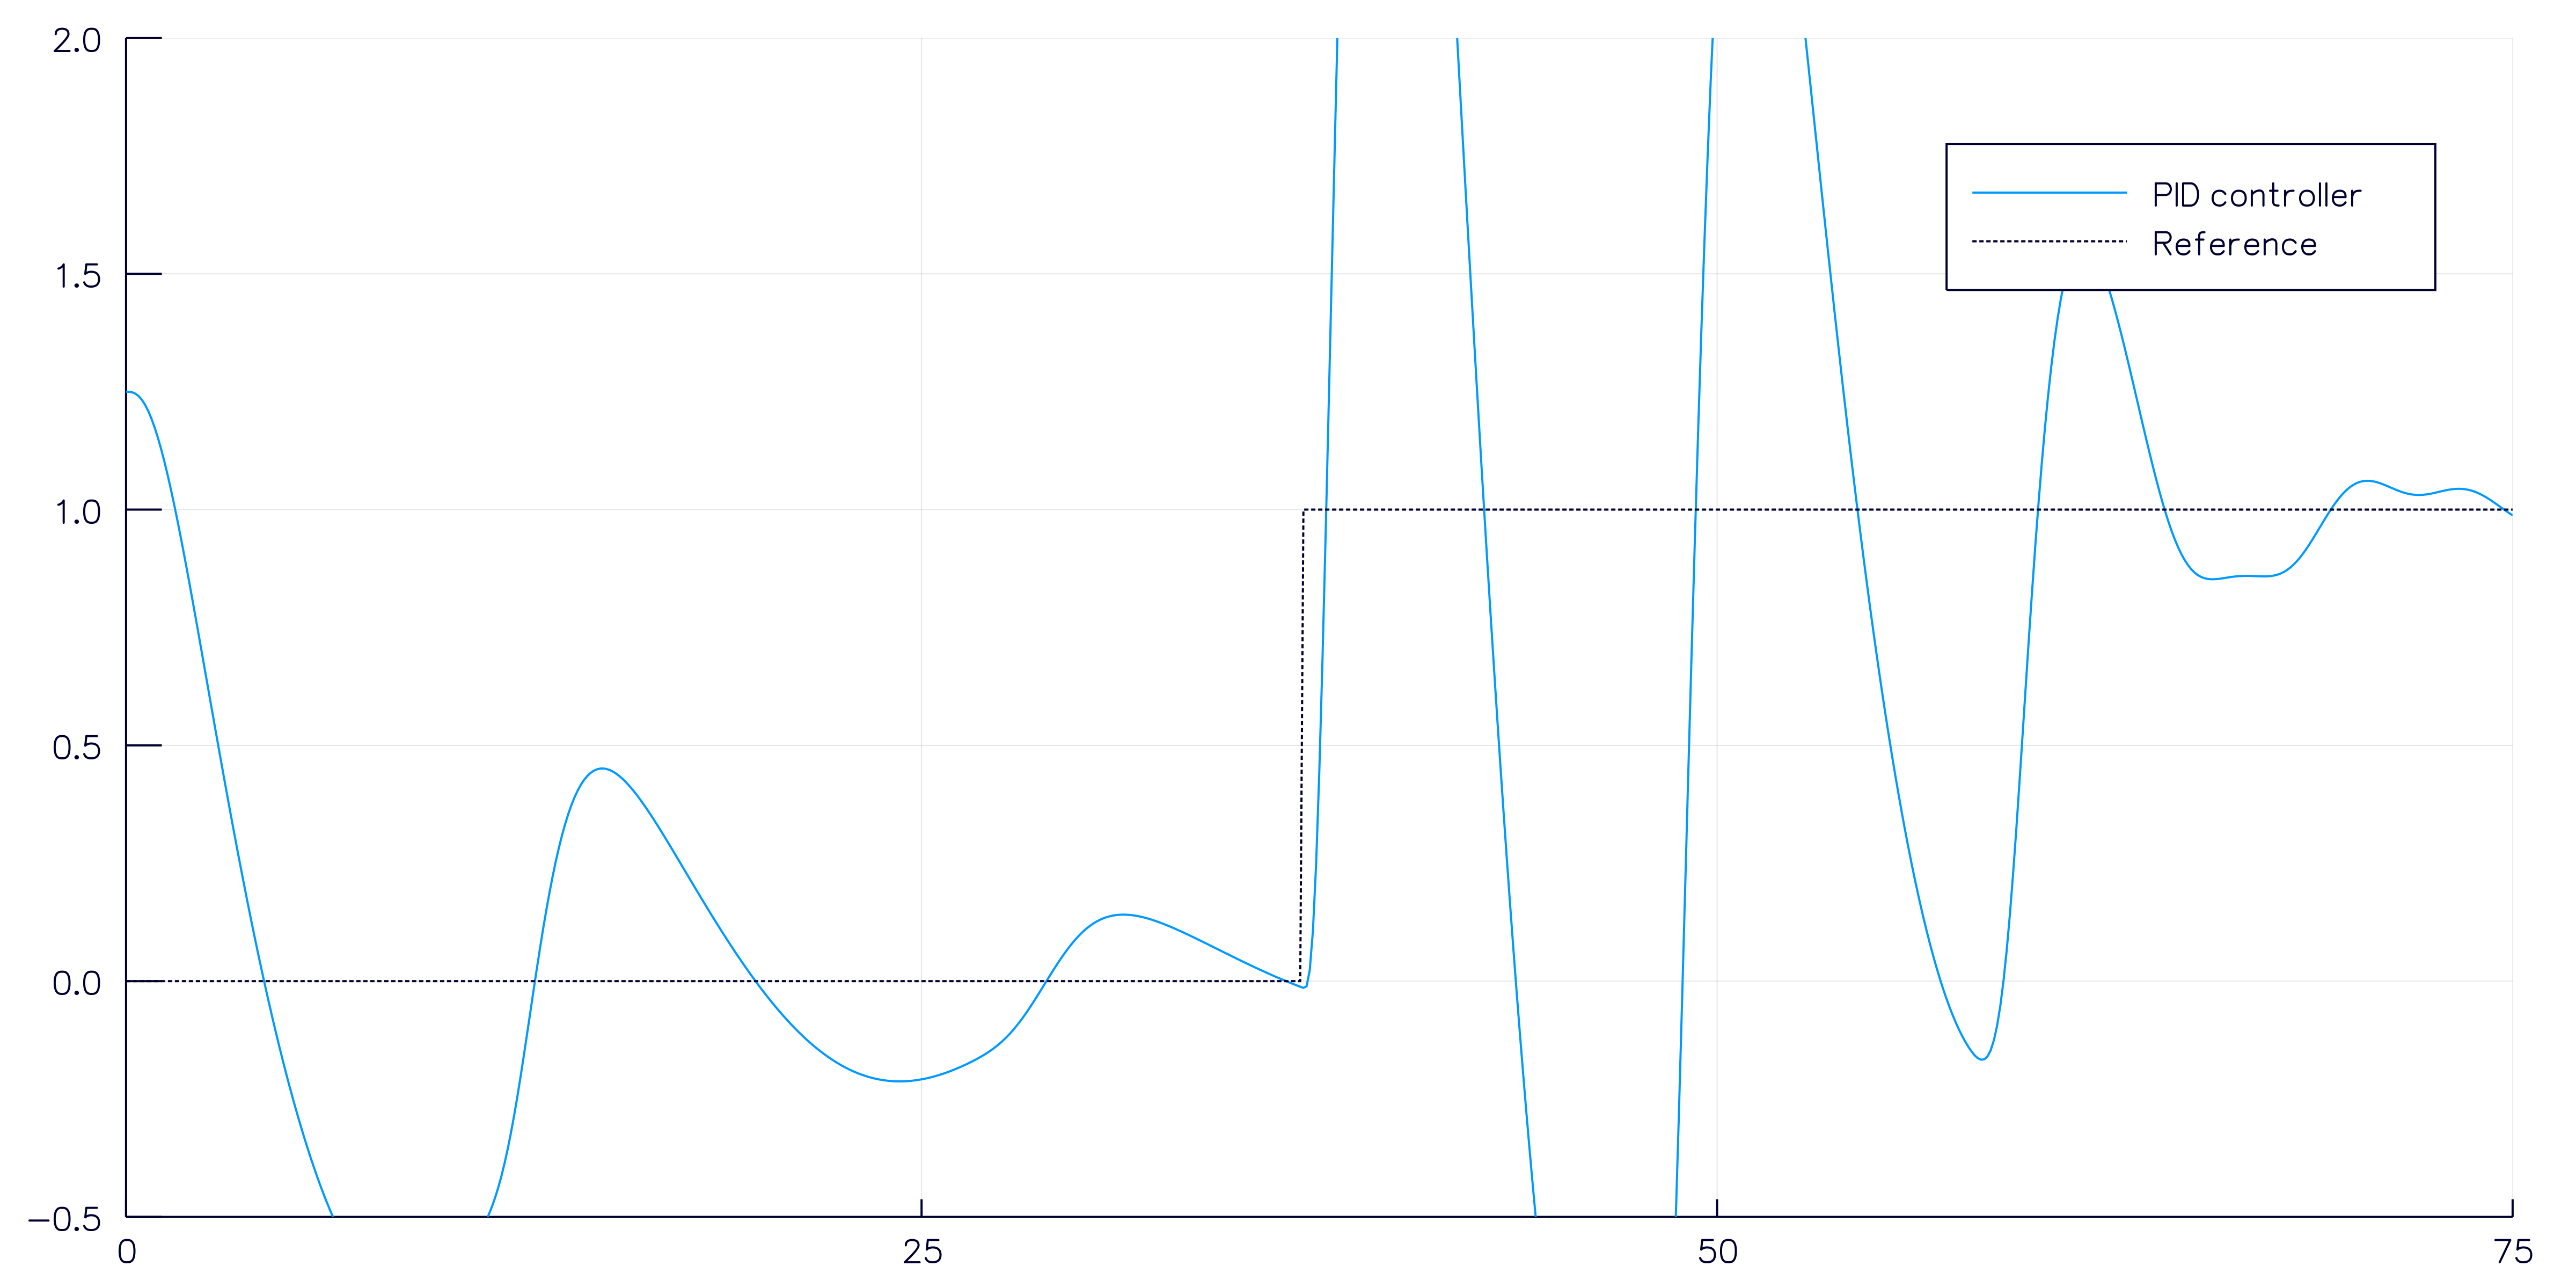

In [31]:
Tf = 75.
tspan = (0.,Tf)
t = 0:h:Tf
x0 = [0,0,5/2]
conditions  = [(x,y,r) -> true]
reference(x,t) = t < Tf÷2 ? 0. : 1.
@manipulate for kp = linspace(0,10,50),ki = linspace(0,8,50),kd = linspace(0,20,50)
    global controllers
    controllers = [pid(kp=kp, ki=ki, kd=kd)]
    global gs, sol2
    gs    = GainSchedulingSimulator(Ps, reference, controllers, conditions, inputfun=(u,t)->nonlinearity.(u))
    sol2  = solve(gs, x0, tspan, Tsit5())
    plot(t, gs.y(sol2, t)[:], lab="PID controller")
    plot!(t, reference.(0,t), lab="Reference", l=:dash, c=:black, ylims=(-0.5,2.))
end

Once again, we try a controller with gain scheduling. The left plot displays the control signal of the two controllers.

Interact.Options{:SelectionSlider,Any}(201: "input-88" = 9.795918367346939 Any , "kp1", 9.795918367346939, "9.795918367346939", 25, Interact.OptionDict(DataStructures.OrderedDict{Any,Any}("0.0"=>0.0,"0.40816326530612246"=>0.408163,"0.8163265306122449"=>0.816327,"1.2244897959183674"=>1.22449,"1.6326530612244898"=>1.63265,"2.0408163265306123"=>2.04082,"2.4489795918367347"=>2.44898,"2.857142857142857"=>2.85714,"3.2653061224489797"=>3.26531,"3.673469387755102"=>3.67347…), Dict{Any,Any}(Pair{Any,Any}(9.38776, "9.387755102040817"),Pair{Any,Any}(8.57143, "8.571428571428571"),Pair{Any,Any}(1.22449, "1.2244897959183674"),Pair{Any,Any}(1.63265, "1.6326530612244898"),Pair{Any,Any}(6.93878, "6.938775510204081"),Pair{Any,Any}(12.6531, "12.653061224489797"),Pair{Any,Any}(19.5918, "19.591836734693878"),Pair{Any,Any}(18.3673, "18.367346938775512"),Pair{Any,Any}(20.0, "20.0"),Pair{Any,Any}(3.67347, "3.673469387755102")…)), Any[], Any[], true, "horizontal")

Interact.Options{:SelectionSlider,Any}(203: "input-89" = 3.9183673469387754 Any , "ki1", 3.9183673469387754, "3.9183673469387754", 25, Interact.OptionDict(DataStructures.OrderedDict{Any,Any}("0.0"=>0.0,"0.16326530612244897"=>0.163265,"0.32653061224489793"=>0.326531,"0.4897959183673469"=>0.489796,"0.6530612244897959"=>0.653061,"0.8163265306122449"=>0.816327,"0.9795918367346939"=>0.979592,"1.1428571428571428"=>1.14286,"1.3061224489795917"=>1.30612,"1.469387755102041"=>1.46939…), Dict{Any,Any}(Pair{Any,Any}(3.59184, "3.5918367346938775"),Pair{Any,Any}(6.85714, "6.857142857142857"),Pair{Any,Any}(1.95918, "1.9591836734693877"),Pair{Any,Any}(8.0, "8.0"),Pair{Any,Any}(1.63265, "1.6326530612244898"),Pair{Any,Any}(6.20408, "6.204081632653061"),Pair{Any,Any}(7.67347, "7.673469387755102"),Pair{Any,Any}(2.61224, "2.6122448979591835"),Pair{Any,Any}(4.57143, "4.571428571428571"),Pair{Any,Any}(1.79592, "1.7959183673469388")…)), Any[], Any[], true, "horizontal")

Interact.Options{:SelectionSlider,Any}(205: "input-90" = 4.8979591836734695 Any , "kd1", 4.8979591836734695, "4.8979591836734695", 25, Interact.OptionDict(DataStructures.OrderedDict{Any,Any}("0.0"=>0.0,"0.20408163265306123"=>0.204082,"0.40816326530612246"=>0.408163,"0.6122448979591837"=>0.612245,"0.8163265306122449"=>0.816327,"1.0204081632653061"=>1.02041,"1.2244897959183674"=>1.22449,"1.4285714285714286"=>1.42857,"1.6326530612244898"=>1.63265,"1.836734693877551"=>1.83673…), Dict{Any,Any}(Pair{Any,Any}(8.77551, "8.775510204081632"),Pair{Any,Any}(7.55102, "7.551020408163265"),Pair{Any,Any}(8.36735, "8.36734693877551"),Pair{Any,Any}(9.38776, "9.387755102040817"),Pair{Any,Any}(8.57143, "8.571428571428571"),Pair{Any,Any}(1.22449, "1.2244897959183674"),Pair{Any,Any}(1.63265, "1.6326530612244898"),Pair{Any,Any}(6.93878, "6.938775510204081"),Pair{Any,Any}(6.32653, "6.326530612244898"),Pair{Any,Any}(3.67347, "3.673469387755102")…)), Any[], Any[], true, "horizontal")

Interact.Options{:SelectionSlider,Any}(207: "input-91" = 4.8979591836734695 Any , "kp2", 4.8979591836734695, "4.8979591836734695", 25, Interact.OptionDict(DataStructures.OrderedDict{Any,Any}("0.0"=>0.0,"0.20408163265306123"=>0.204082,"0.40816326530612246"=>0.408163,"0.6122448979591837"=>0.612245,"0.8163265306122449"=>0.816327,"1.0204081632653061"=>1.02041,"1.2244897959183674"=>1.22449,"1.4285714285714286"=>1.42857,"1.6326530612244898"=>1.63265,"1.836734693877551"=>1.83673…), Dict{Any,Any}(Pair{Any,Any}(8.77551, "8.775510204081632"),Pair{Any,Any}(7.55102, "7.551020408163265"),Pair{Any,Any}(8.36735, "8.36734693877551"),Pair{Any,Any}(9.38776, "9.387755102040817"),Pair{Any,Any}(8.57143, "8.571428571428571"),Pair{Any,Any}(1.22449, "1.2244897959183674"),Pair{Any,Any}(1.63265, "1.6326530612244898"),Pair{Any,Any}(6.93878, "6.938775510204081"),Pair{Any,Any}(6.32653, "6.326530612244898"),Pair{Any,Any}(3.67347, "3.673469387755102")…)), Any[], Any[], true, "horizontal")

Interact.Options{:SelectionSlider,Any}(209: "input-92" = 3.9183673469387754 Any , "ki2", 3.9183673469387754, "3.9183673469387754", 25, Interact.OptionDict(DataStructures.OrderedDict{Any,Any}("0.0"=>0.0,"0.16326530612244897"=>0.163265,"0.32653061224489793"=>0.326531,"0.4897959183673469"=>0.489796,"0.6530612244897959"=>0.653061,"0.8163265306122449"=>0.816327,"0.9795918367346939"=>0.979592,"1.1428571428571428"=>1.14286,"1.3061224489795917"=>1.30612,"1.469387755102041"=>1.46939…), Dict{Any,Any}(Pair{Any,Any}(3.59184, "3.5918367346938775"),Pair{Any,Any}(6.85714, "6.857142857142857"),Pair{Any,Any}(1.95918, "1.9591836734693877"),Pair{Any,Any}(8.0, "8.0"),Pair{Any,Any}(1.63265, "1.6326530612244898"),Pair{Any,Any}(6.20408, "6.204081632653061"),Pair{Any,Any}(7.67347, "7.673469387755102"),Pair{Any,Any}(2.61224, "2.6122448979591835"),Pair{Any,Any}(4.57143, "4.571428571428571"),Pair{Any,Any}(1.79592, "1.7959183673469388")…)), Any[], Any[], true, "horizontal")

Interact.Options{:SelectionSlider,Any}(211: "input-93" = 3.9183673469387754 Any , "kd2", 3.9183673469387754, "3.9183673469387754", 25, Interact.OptionDict(DataStructures.OrderedDict{Any,Any}("0.0"=>0.0,"0.16326530612244897"=>0.163265,"0.32653061224489793"=>0.326531,"0.4897959183673469"=>0.489796,"0.6530612244897959"=>0.653061,"0.8163265306122449"=>0.816327,"0.9795918367346939"=>0.979592,"1.1428571428571428"=>1.14286,"1.3061224489795917"=>1.30612,"1.469387755102041"=>1.46939…), Dict{Any,Any}(Pair{Any,Any}(3.59184, "3.5918367346938775"),Pair{Any,Any}(6.85714, "6.857142857142857"),Pair{Any,Any}(1.95918, "1.9591836734693877"),Pair{Any,Any}(8.0, "8.0"),Pair{Any,Any}(1.63265, "1.6326530612244898"),Pair{Any,Any}(6.20408, "6.204081632653061"),Pair{Any,Any}(7.67347, "7.673469387755102"),Pair{Any,Any}(2.61224, "2.6122448979591835"),Pair{Any,Any}(4.57143, "4.571428571428571"),Pair{Any,Any}(1.79592, "1.7959183673469388")…)), Any[], Any[], true, "horizontal")

Interact.Options{:SelectionSlider,Any}(213: "input-94" = 0.47368421052631576 Any , "th", 0.47368421052631576, "0.47368421052631576", 10, Interact.OptionDict(DataStructures.OrderedDict{Any,Any}("0.0"=>0.0,"0.05263157894736842"=>0.0526316,"0.10526315789473684"=>0.105263,"0.15789473684210525"=>0.157895,"0.21052631578947367"=>0.210526,"0.2631578947368421"=>0.263158,"0.3157894736842105"=>0.315789,"0.3684210526315789"=>0.368421,"0.42105263157894735"=>0.421053,"0.47368421052631576"=>0.473684…), Dict{Any,Any}(Pair{Any,Any}(1.0, "1.0"),Pair{Any,Any}(0.0526316, "0.05263157894736842"),Pair{Any,Any}(0.947368, "0.9473684210526315"),Pair{Any,Any}(0.789474, "0.7894736842105263"),Pair{Any,Any}(0.0, "0.0"),Pair{Any,Any}(0.368421, "0.3684210526315789"),Pair{Any,Any}(0.263158, "0.2631578947368421"),Pair{Any,Any}(0.894737, "0.8947368421052632"),Pair{Any,Any}(0.526316, "0.5263157894736842"),Pair{Any,Any}(0.473684, "0.47368421052631576")…)), Any[], Any[], true, "horizontal")

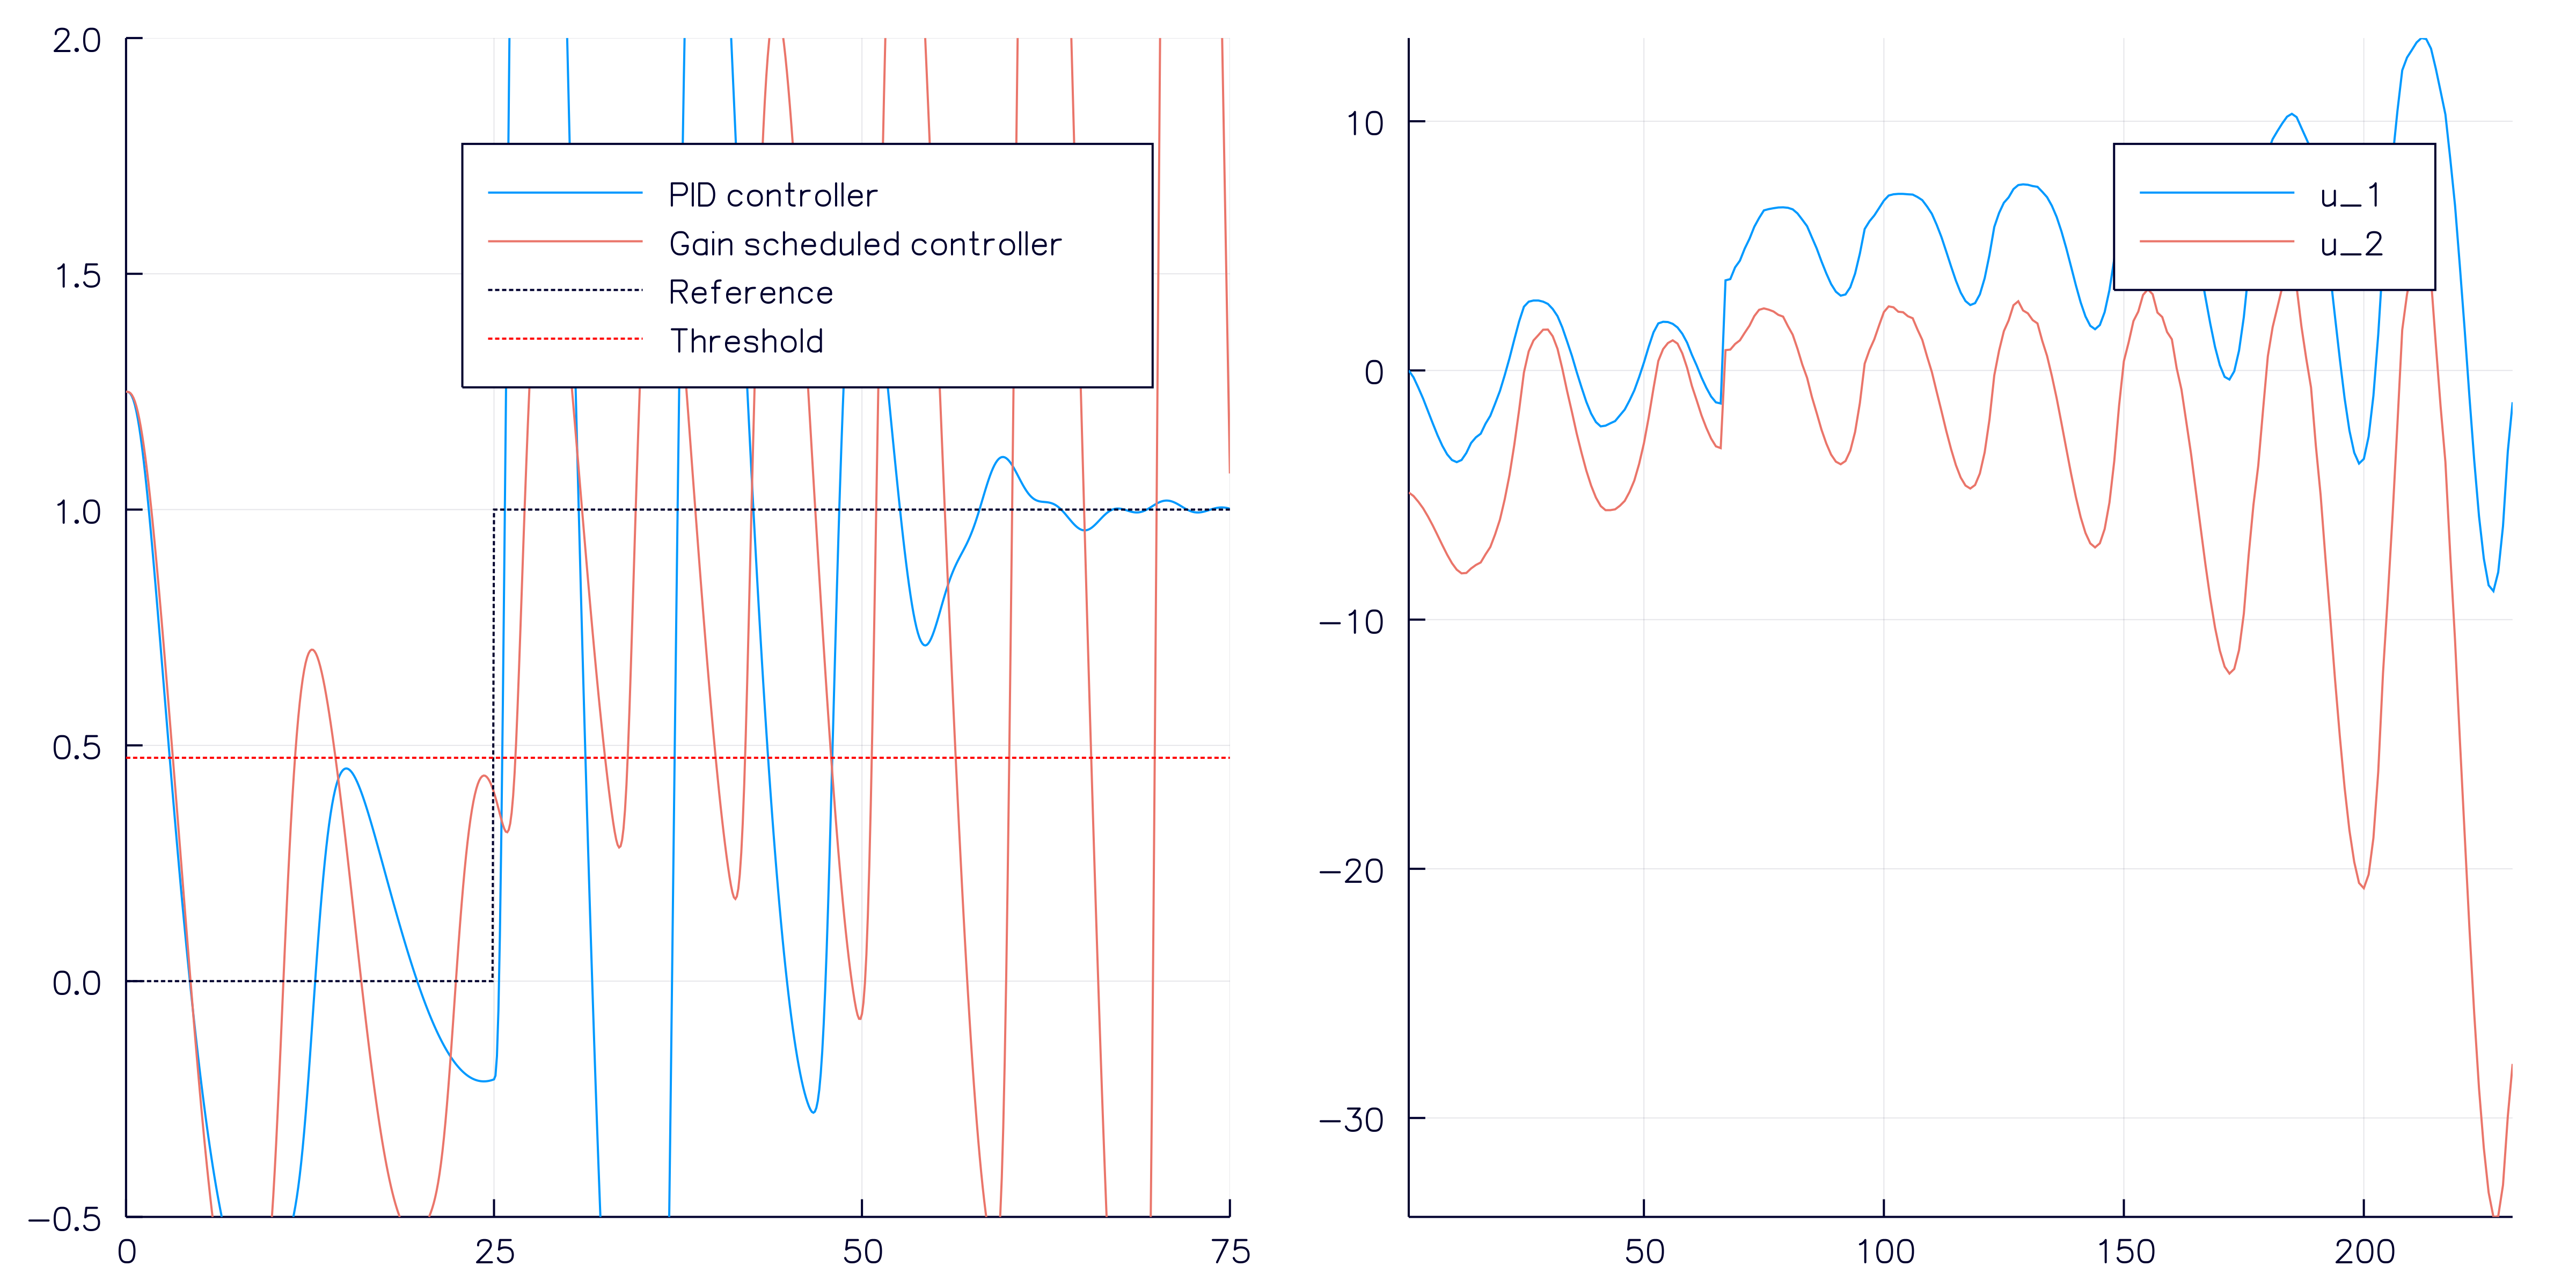

In [32]:
gs    = GainSchedulingSimulator(Ps, reference, controllers, conditions, inputfun=(u,t)->nonlinearity.(u) .+ disturbance(t,0))
Tf    = 75.
tspan = (0.,Tf)
t     = 0:h:Tf
reference(x,t) = t < Tf÷3 ? 0. : 1.
disturbance(x,t) = 0 # t < 2Tf÷3 ? 0. : -1.
@manipulate for kp1 = linspace(0,20,50),ki1 = linspace(0,8,50),kd1 = linspace(0,10,50),kp2 = linspace(0,10,50),ki2 = linspace(0,8,50),kd2 = linspace(0,8,50),th  = linspace(0,1,20)
    
    # kp1,ki1,kp2,ki2,th = 1,1,1,1,0.5
    global sol3
    sol2  = solve(gs, x0, tspan, Tsit5())
    plot(t, gs.y(sol2, t)[:], lab="PID controller", layout=2)

    controllers  = ss.([pid(kp=kp1, ki=ki1, kd=kd1), pid(kp=kp2, ki=ki2, kd=kd2)])
    conditions   = [(x,y,r) -> y[1] < th, (x,y,r) -> y[1] >= th]
    gs2          = GainSchedulingSimulator(Ps, reference, controllers, conditions,
                        inputfun=(u,t)->nonlinearity.(u) .+ disturbance(0,t))
    sol3         = solve(gs2, x0, tspan, Tsit5(), reltol=1e-4, abstol=1e-4)

    # Plotting
    U  = hcat(sol3.u...)
    x  = [[u[1],u[2],u[3]] for u in sol3.u]
    u1 = controllers[1].C*U[3:4,:] + controllers[1].D.*hcat((gs2.e.(x, sol3.t))...)
    u2 = controllers[2].C*U[5:6,:] + controllers[2].D.*hcat((gs2.e.(x, sol3.t))...)
    plot!(t, gs2.y(sol3, t)[:], lab="Gain scheduled controller", ylims=(-0.5,2), subplot=1)
    plot!(t, reference.(0,t), lab="Reference", l=:dash, c=:black, subplot=1)
    plot!([tspan...], [th, th], lab="Threshold", c=:red, l=:dash, subplot=1)
    plot!([u1[:] u2[:]], lab=["u_1" "u_2"], subplot=2)
end

- Can you manage to get a gain scheduled controller that is better than the simple PID controller?
- Add derivative part if needed
- Add an input disturbance by uncommenting "# t < 2Tf÷3 ? 0. : -1.". Does your scheduling still work as well?
- Study the implementation of gain-scheduling. Do you notice any issues with the implementation of the gain scheduling? The implementation is available by running the code snippet below.
- How do you resolve any issues you can think of? 

In [33]:
edit(Pkg.dir("ControlSystems","src","simulators.jl"), 219)

To get a better feeling for the practicalities of gain scheduling, you'll be asked to implement a simple gain scheduled controller with interpolation below. We consider the same process and nonlinearity as above, but this time we'll implement two P-controllers and an interpolation region.
- Define two threshold values $t_1$ and $t_2$, between which you interpolate the value of the control signal requested by the two controllers.
- Figure out the equations for linear interpolation between the thresholds, you have two candidate control signals $u_1,u_2$, what is the control signal to output in the following cases, where $p$ is the scheduling signal?
    1. $p < t_1$
    2. $t_1 \leq p < t_2$
    3. $p \leq t_2$
Add the interpolation logic to the controller below.

Interact.Options{:SelectionSlider,Any}(217: "input-95" = 4.8979591836734695 Any , "K1", 4.8979591836734695, "4.8979591836734695", 25, Interact.OptionDict(DataStructures.OrderedDict{Any,Any}("0.0"=>0.0,"0.20408163265306123"=>0.204082,"0.40816326530612246"=>0.408163,"0.6122448979591837"=>0.612245,"0.8163265306122449"=>0.816327,"1.0204081632653061"=>1.02041,"1.2244897959183674"=>1.22449,"1.4285714285714286"=>1.42857,"1.6326530612244898"=>1.63265,"1.836734693877551"=>1.83673…), Dict{Any,Any}(Pair{Any,Any}(8.77551, "8.775510204081632"),Pair{Any,Any}(7.55102, "7.551020408163265"),Pair{Any,Any}(8.36735, "8.36734693877551"),Pair{Any,Any}(9.38776, "9.387755102040817"),Pair{Any,Any}(8.57143, "8.571428571428571"),Pair{Any,Any}(1.22449, "1.2244897959183674"),Pair{Any,Any}(1.63265, "1.6326530612244898"),Pair{Any,Any}(6.93878, "6.938775510204081"),Pair{Any,Any}(6.32653, "6.326530612244898"),Pair{Any,Any}(3.67347, "3.673469387755102")…)), Any[], Any[], true, "horizontal")

Interact.Options{:SelectionSlider,Any}(219: "input-96" = 2.4489795918367347 Any , "K2", 2.4489795918367347, "2.4489795918367347", 25, Interact.OptionDict(DataStructures.OrderedDict{Any,Any}("0.0"=>0.0,"0.10204081632653061"=>0.102041,"0.20408163265306123"=>0.204082,"0.30612244897959184"=>0.306122,"0.40816326530612246"=>0.408163,"0.5102040816326531"=>0.510204,"0.6122448979591837"=>0.612245,"0.7142857142857143"=>0.714286,"0.8163265306122449"=>0.816327,"0.9183673469387755"=>0.918367…), Dict{Any,Any}(Pair{Any,Any}(1.22449, "1.2244897959183674"),Pair{Any,Any}(1.63265, "1.6326530612244898"),Pair{Any,Any}(4.79592, "4.795918367346939"),Pair{Any,Any}(2.14286, "2.142857142857143"),Pair{Any,Any}(3.77551, "3.7755102040816326"),Pair{Any,Any}(3.67347, "3.673469387755102"),Pair{Any,Any}(2.04082, "2.0408163265306123"),Pair{Any,Any}(0.612245, "0.6122448979591837"),Pair{Any,Any}(3.87755, "3.877551020408163"),Pair{Any,Any}(1.12245, "1.1224489795918366")…)), Any[], Any[], true, "horizontal")

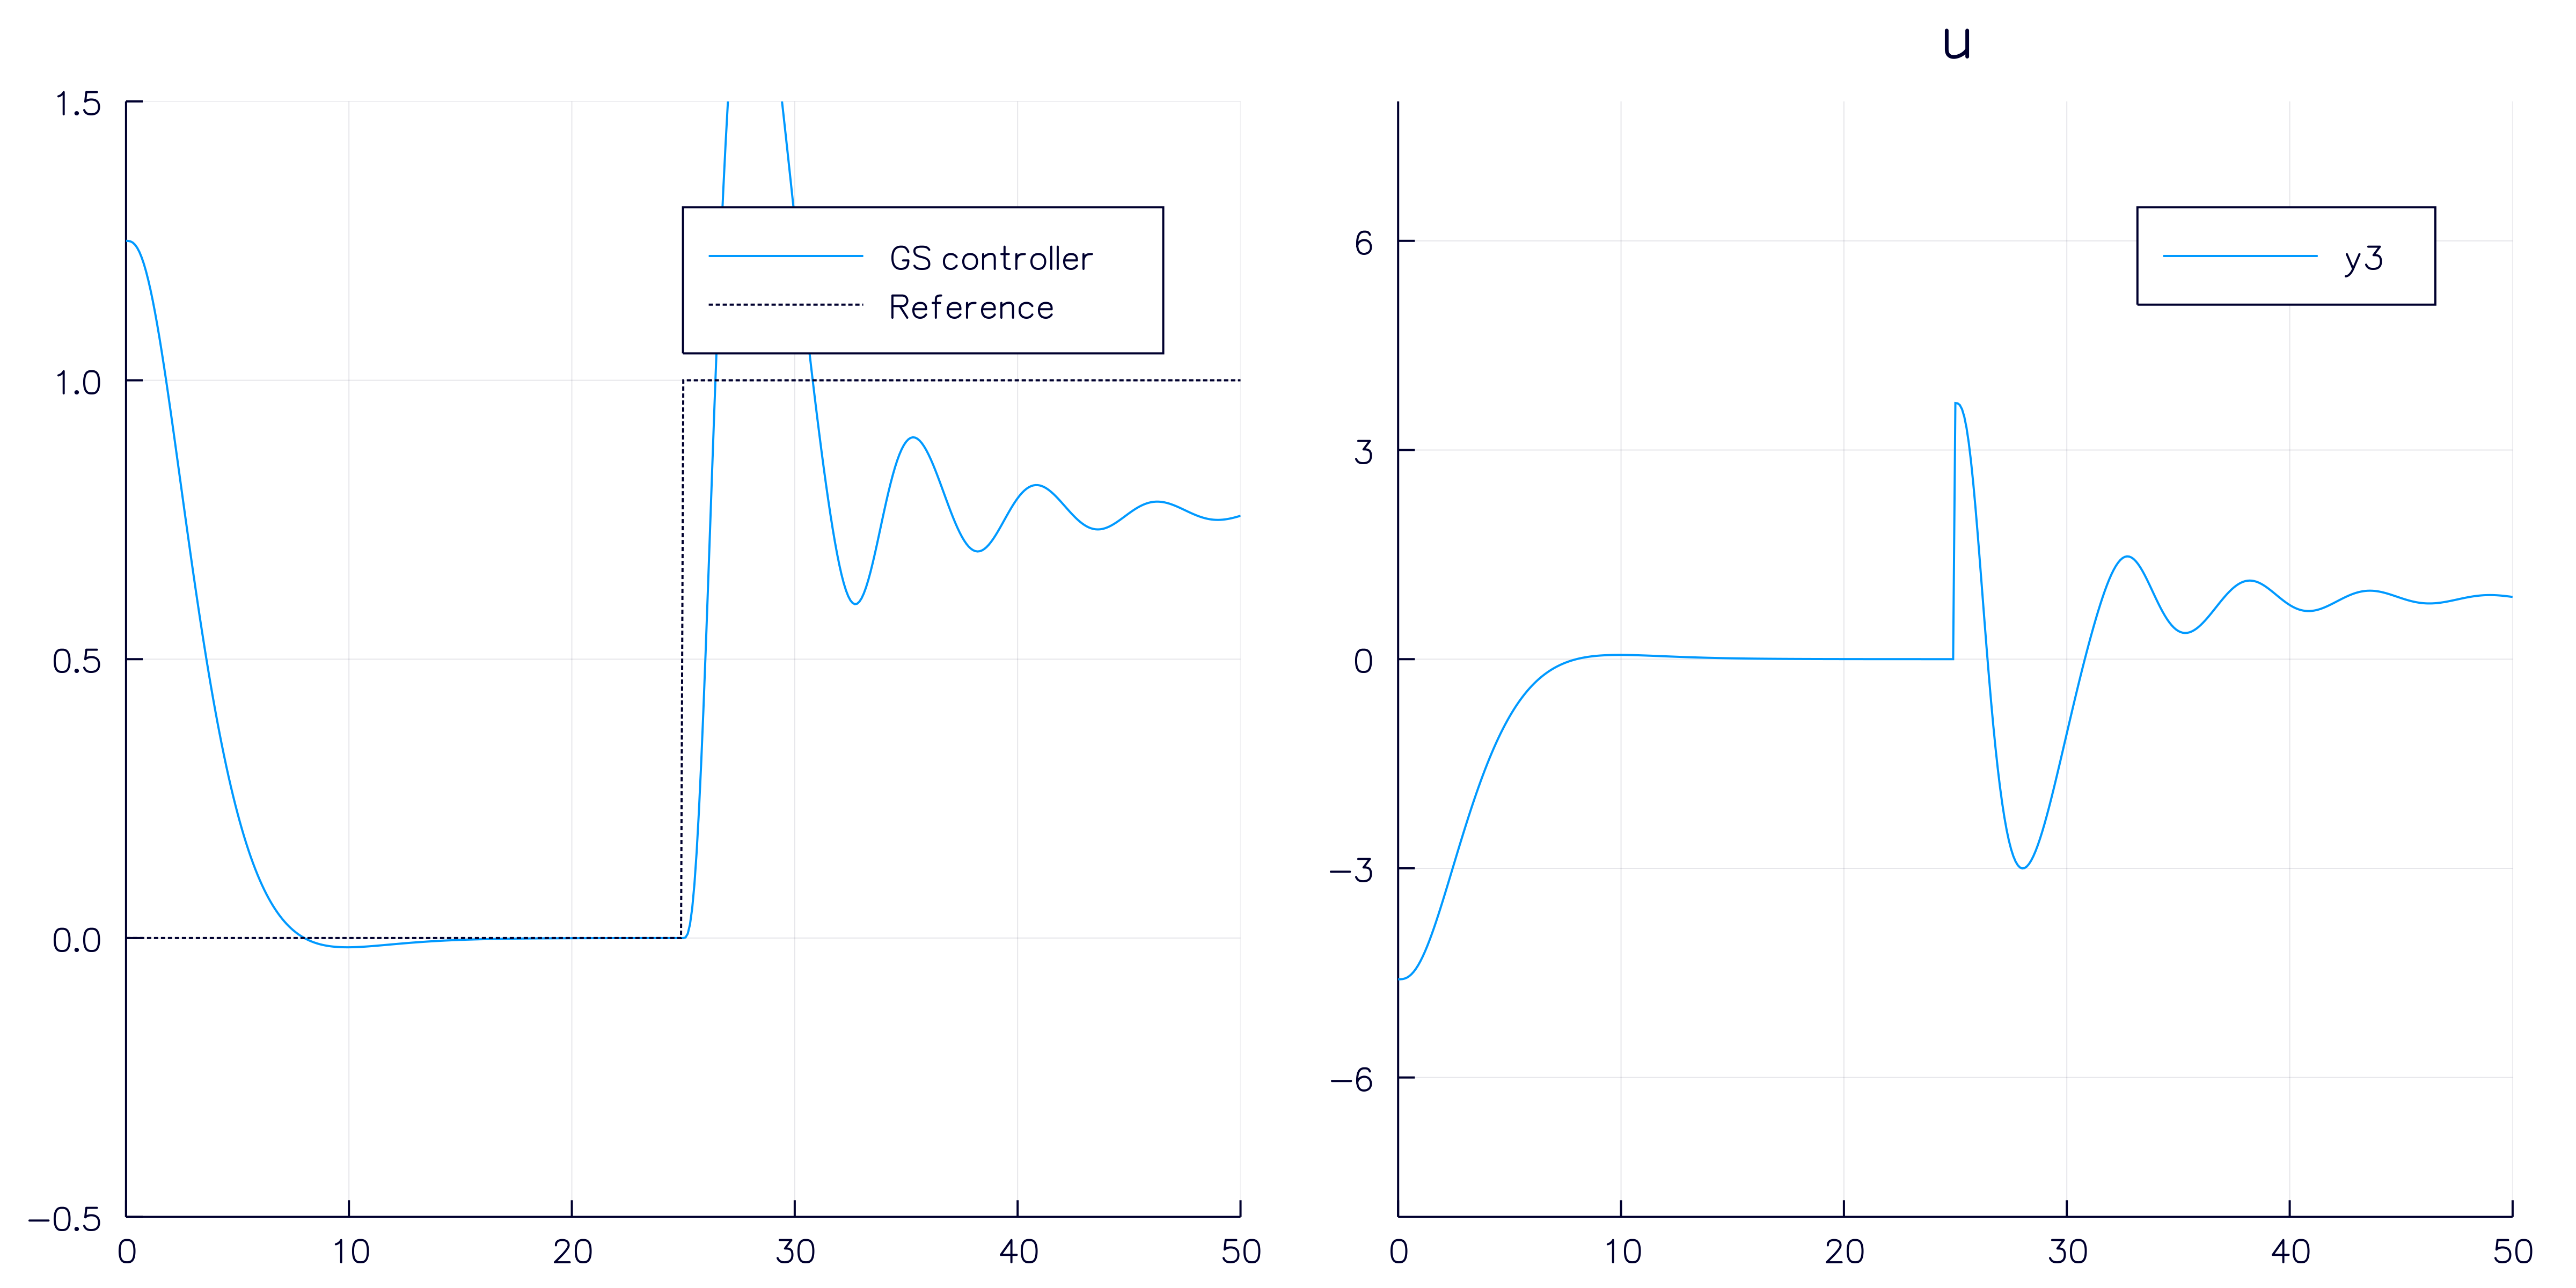

In [34]:
Tf             = 50                 # Length of experiments (seconds)
t              = 0:h:Tf             # Time vector
reference(x,t) = t < Tf÷2 ? 0. : 1. # Reference generator (step function)
s              = Simulator(Ps)
x0             = [0.,0,5/2]         # Initial state
tspan          = (0.0,Tf)

@manipulate for K1 = linspace(0,10,50), K2 = linspace(0,5,50)

    function controller(x,t)
        y  = Ps.C*x # Form measurement signal
        e  = reference(x,t) .- y
        u1 = K1*e
        u2 = K2*e
        
        u  = (u1+u2) / 2 # Implement the interpolation here! <-----------------------------

        return u
    end
    
    s    = Simulator(Ps,(u->nonlinearity.(u)) ∘ controller)
    solg = solve(s, x0, tspan, Tsit5()) # Simulate the system
    plot(t, s.y(solg, t)[:], lab="GS controller", layout=2, subplot=1)
    plot!(t, reference.(0,t), lab="Reference", l=:dash, c=:black, ylims=(-0.5,1.5), subplot=1)
    plot!(t, [controller(solg(t),t)[] for t ∈ t], title="u", ylims=(-8,8), subplot=2)
end

You can add sliders for $t_1$ and $t_2$ to make experimentation faster.
- Which signal is your preferred choice of scheduling signal?

Tuning a gain schedule and the parameters of the scheduled controllers can become very tedious. Even more so it the process time constant is long and one does not have a simulator. A more systematic apporach is to linearize the system around two different operating points and design a well-damped controller for both linear systems. One then chooses a threshold somewhere between the operating points. Linearize the system around two operating points, you can do this either manually or with the help of the computer. The process model on statespace form is given by:

In [ ]:
Ps

After having linearized the system, modify the controller implementation above to get a better behaviour in a large part of the workspace.